## **Import Packages**

In [64]:
import os
import librosa
import random
import numpy as np
import pandas as pd
import soundfile as sf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers, models 
from keras.callbacks  import ReduceLROnPlateau, EarlyStopping

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [65]:
# seed configuration 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [66]:
# data path 
DATA_PATH = "ESC-50-master/"
CSV_PATH = os.path.join(DATA_PATH, "meta/esc50.csv")
AUDIO_PATH = os.path.join(DATA_PATH, "audio")
AUGMENTED_PATH = "ESC-50-augmented-data"

## **Load Data**

In [67]:
dataset = pd.read_csv(CSV_PATH)
dataset["files_path"] = dataset["filename"].apply(lambda x: os.path.join(AUDIO_PATH, x))

# ✅ Encode label 
encoder = LabelEncoder()
dataset["target"] = encoder.fit_transform(dataset["category"])
num_classes = len(encoder.classes_)

In [68]:
dataset.head()

filename  fold  target        category  esc10  src_file take  \
0   1-100032-A-0.wav     1      18             dog   True    100032    A   
1  1-100038-A-14.wav     1       7  chirping_birds  False    100038    A   
2  1-100210-A-36.wav     1      46  vacuum_cleaner  False    100210    A   
3  1-100210-B-36.wav     1      46  vacuum_cleaner  False    100210    B   
4  1-101296-A-19.wav     1      43    thunderstorm  False    101296    A   

                              files_path  
0   ESC-50-master/audio\1-100032-A-0.wav  
1  ESC-50-master/audio\1-100038-A-14.wav  
2  ESC-50-master/audio\1-100210-A-36.wav  
3  ESC-50-master/audio\1-100210-B-36.wav  
4  ESC-50-master/audio\1-101296-A-19.wav

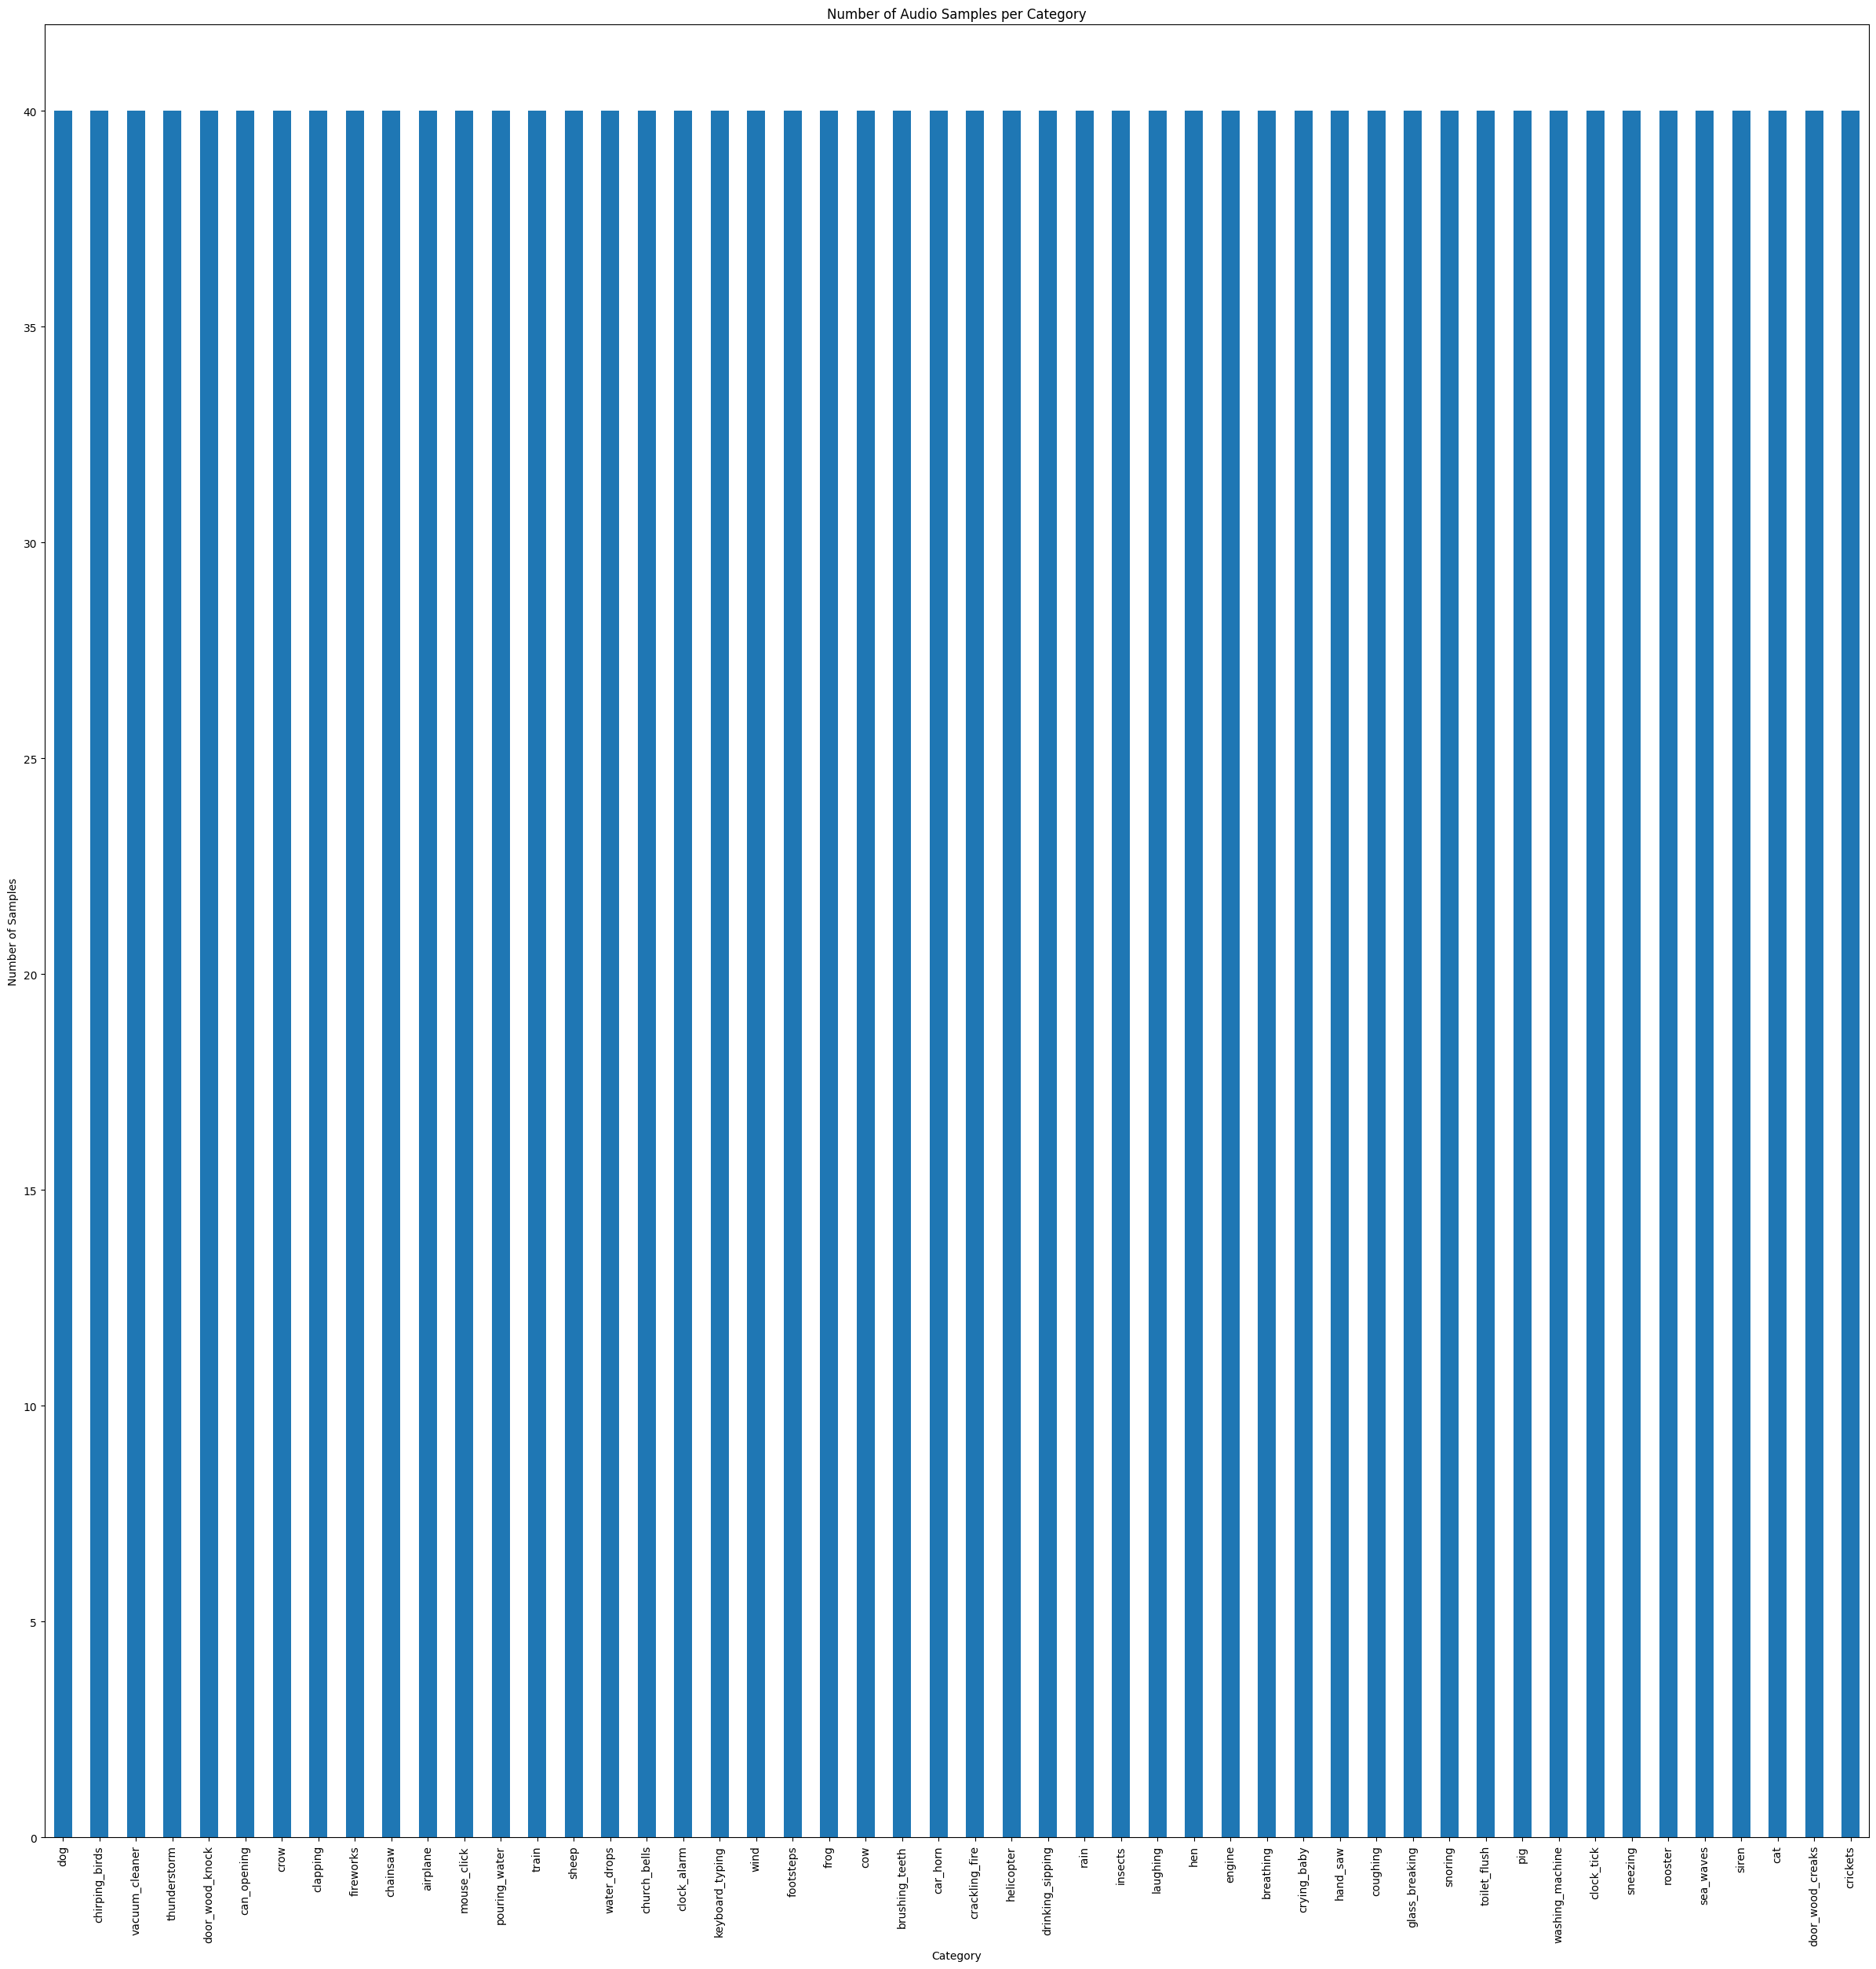

In [69]:
category_group = dataset['category'].value_counts()
plot = category_group.plot(kind='bar', title="Number of Audio Samples per Category", figsize=(30,30))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [70]:
# get all sound files 
all_files = []
for path, subdirs, files in os.walk(DATA_PATH):
    for name in files:
        all_files.append(os.path.join(path, name))

In [71]:
plot_files = random.choices(all_files, k = 10)
plot_audios = [librosa.load(plot_files[i]) for i in range(10)]

## **Visualize Data**

In [ ]:
decoder = {
    0: "dog",
    14: "chirping_birds",
    36: "vacuum_cleaner",
    19: "thunderstorm",
    30: "door_wood_knock",
    34: "can_opening",
    9: "crow",
    22: "clapping",
    48: "fireworks",
    41: "chainsaw",
    47: "airplane",
    31: "mouse_click",
    17: "pouring_water",
    45: "train",
    8: "sheep",
    15: "water_drops",
    46: "church_bells",
    37: "clock_alarm",
    32: "keyboard_typing",
    16: "wind",
    25: "footsteps",
    4: "frog",
    3: "cow",
    27: "brushing_teeth",
    43: "car_horn",
    12: "crackling_fire",
    40: "helicopter",
    29: "drinking_sipping",
    10: "rain",
    7: "insects",
    26: "laughing",
    6: "hen",
    44: "engine",
    23: "breathing",
    20: "crying_baby",
    49: "hand_saw",
    24: "coughing",
    39: "glass_breaking",
    28: "snoring",
    18: "toilet_flush",
    2: "pig",
    35: "washing_machine",
    38: "clock_tick",
    21: "sneezing",
    1: "rooster",
    11: "sea_waves",
    42: "siren",
    5: "cat",
    33: "door_wood_creaks",
    13: "crickets",
}

encoder = {v: k for k, v in decoder.items()} 

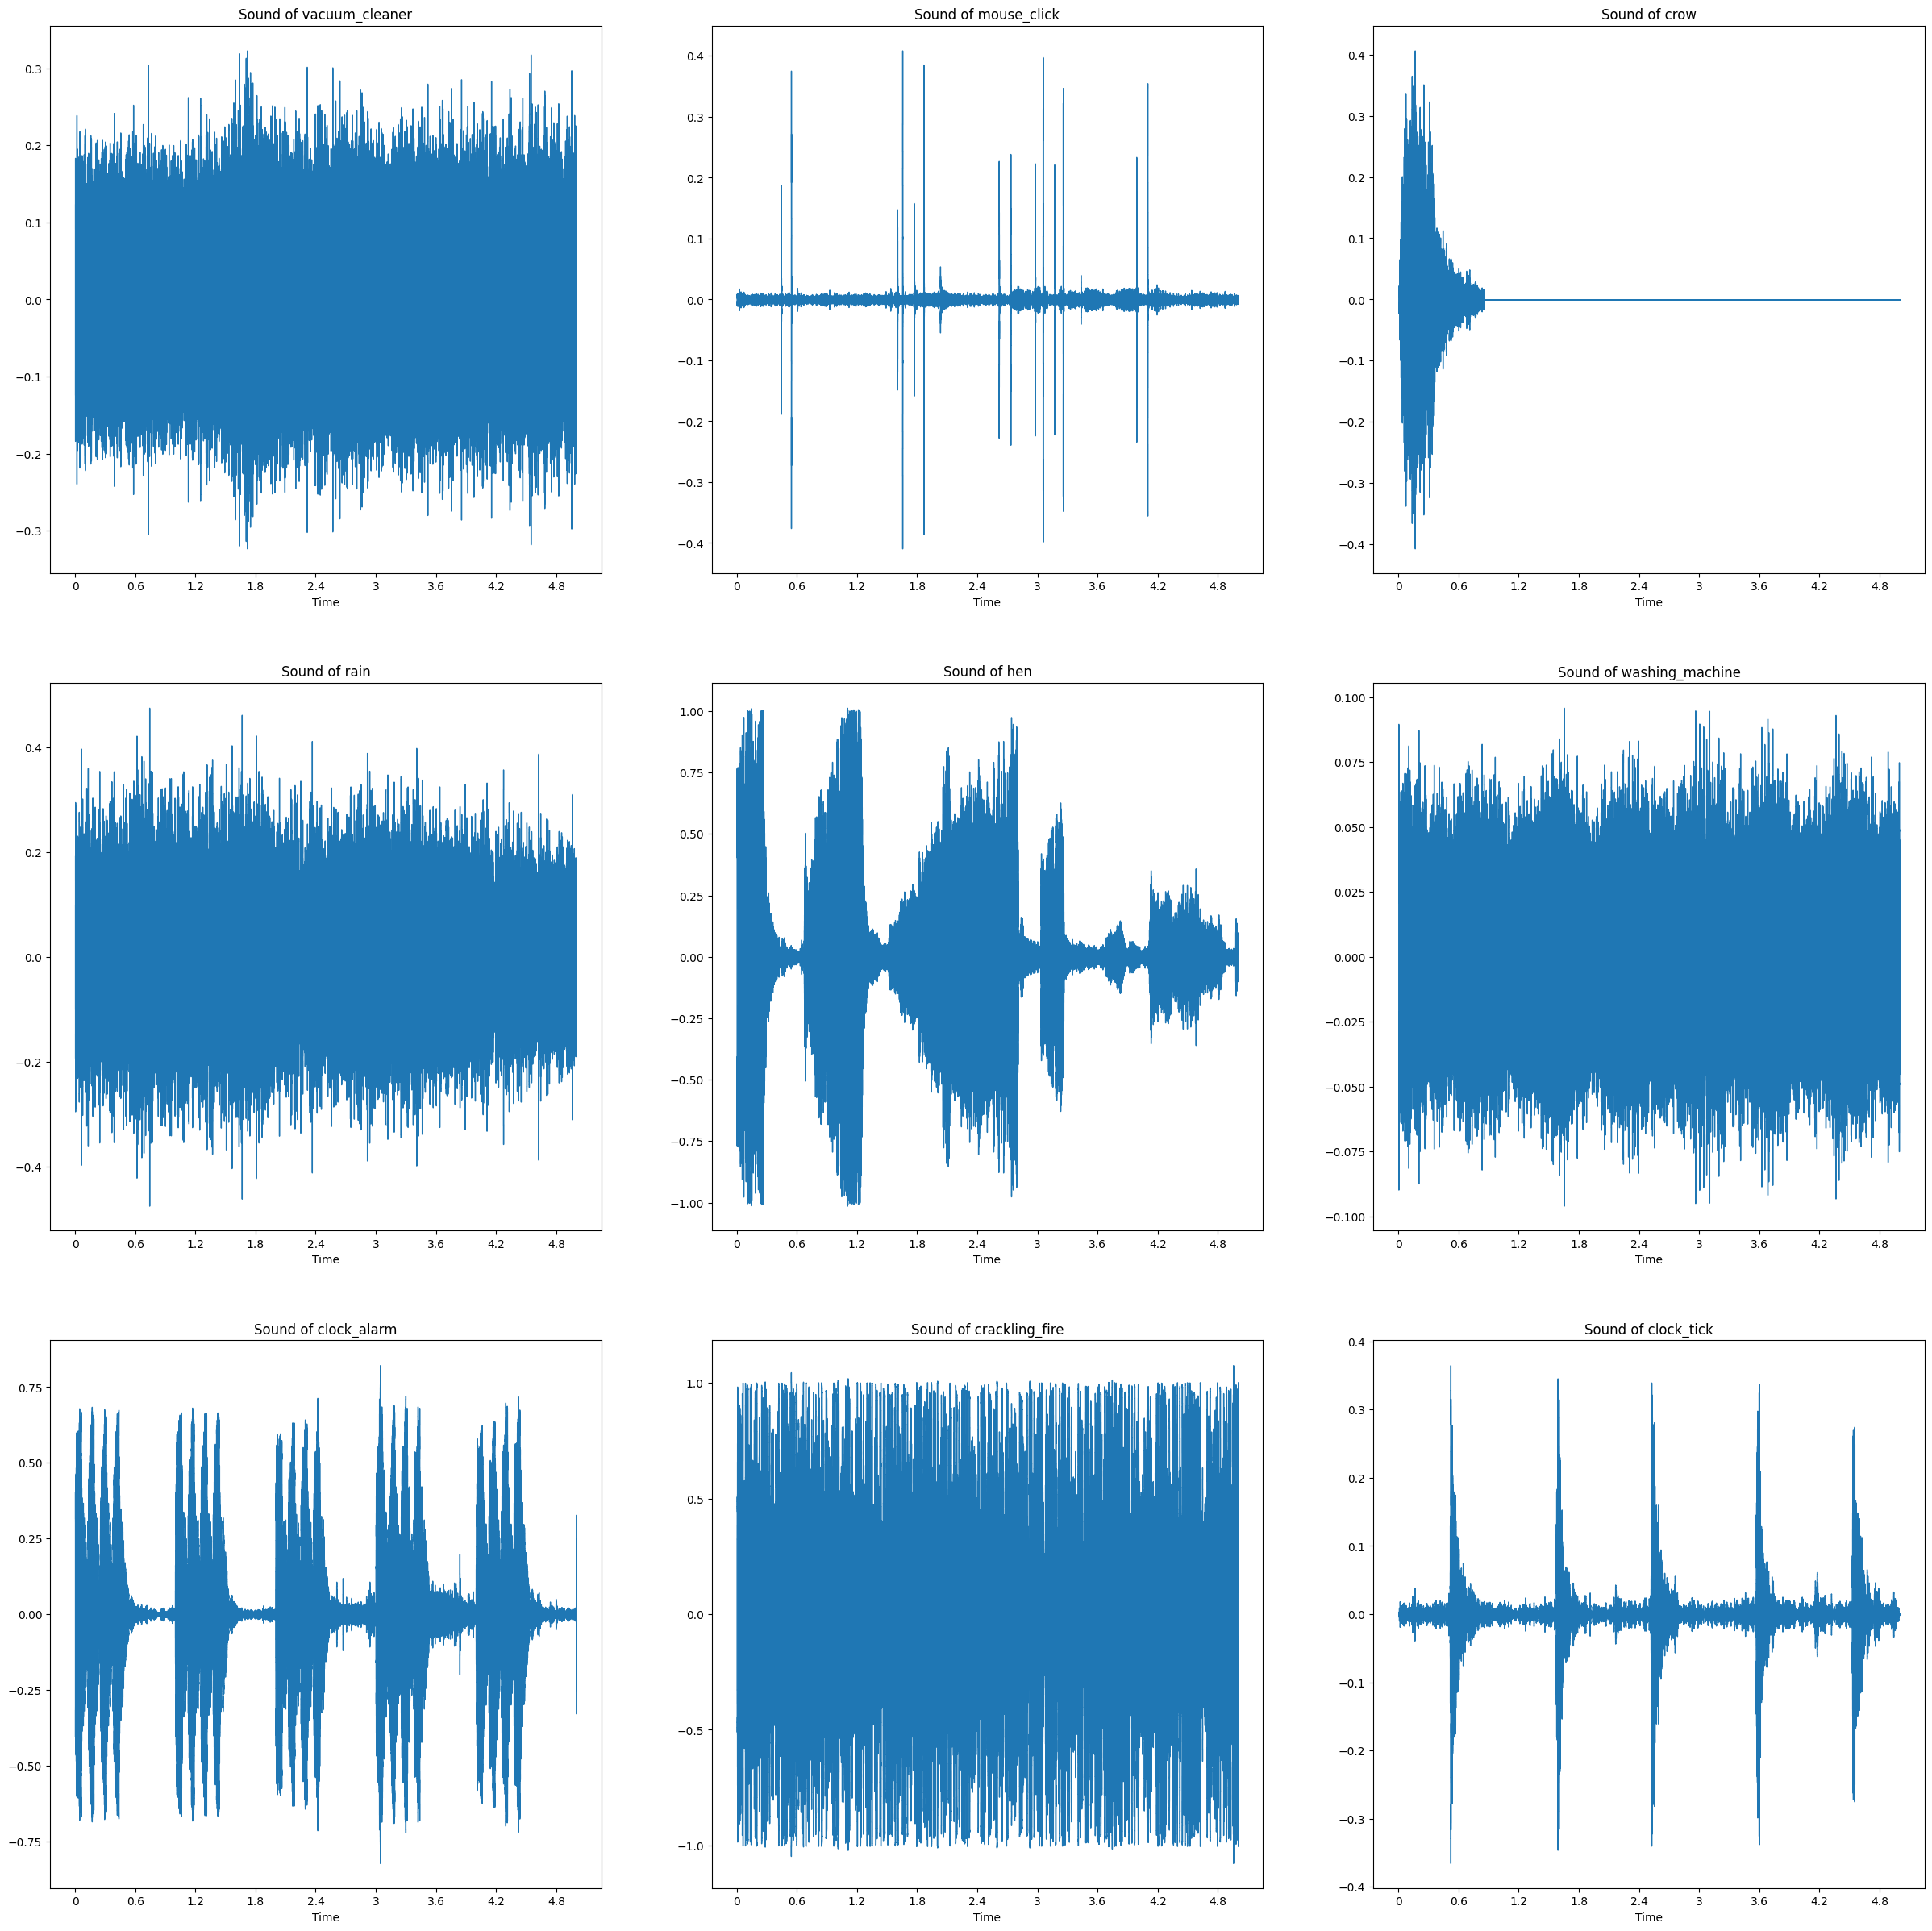

In [11]:
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    librosa.display.waveshow(plot_audios[i][0])
    try:
        plt.title("Sound of " + decoder[int(plot_files[i][-6:-4])] )
    except:
        plt.title("Sound of " + decoder[int(plot_files[i][-5:-4])] )

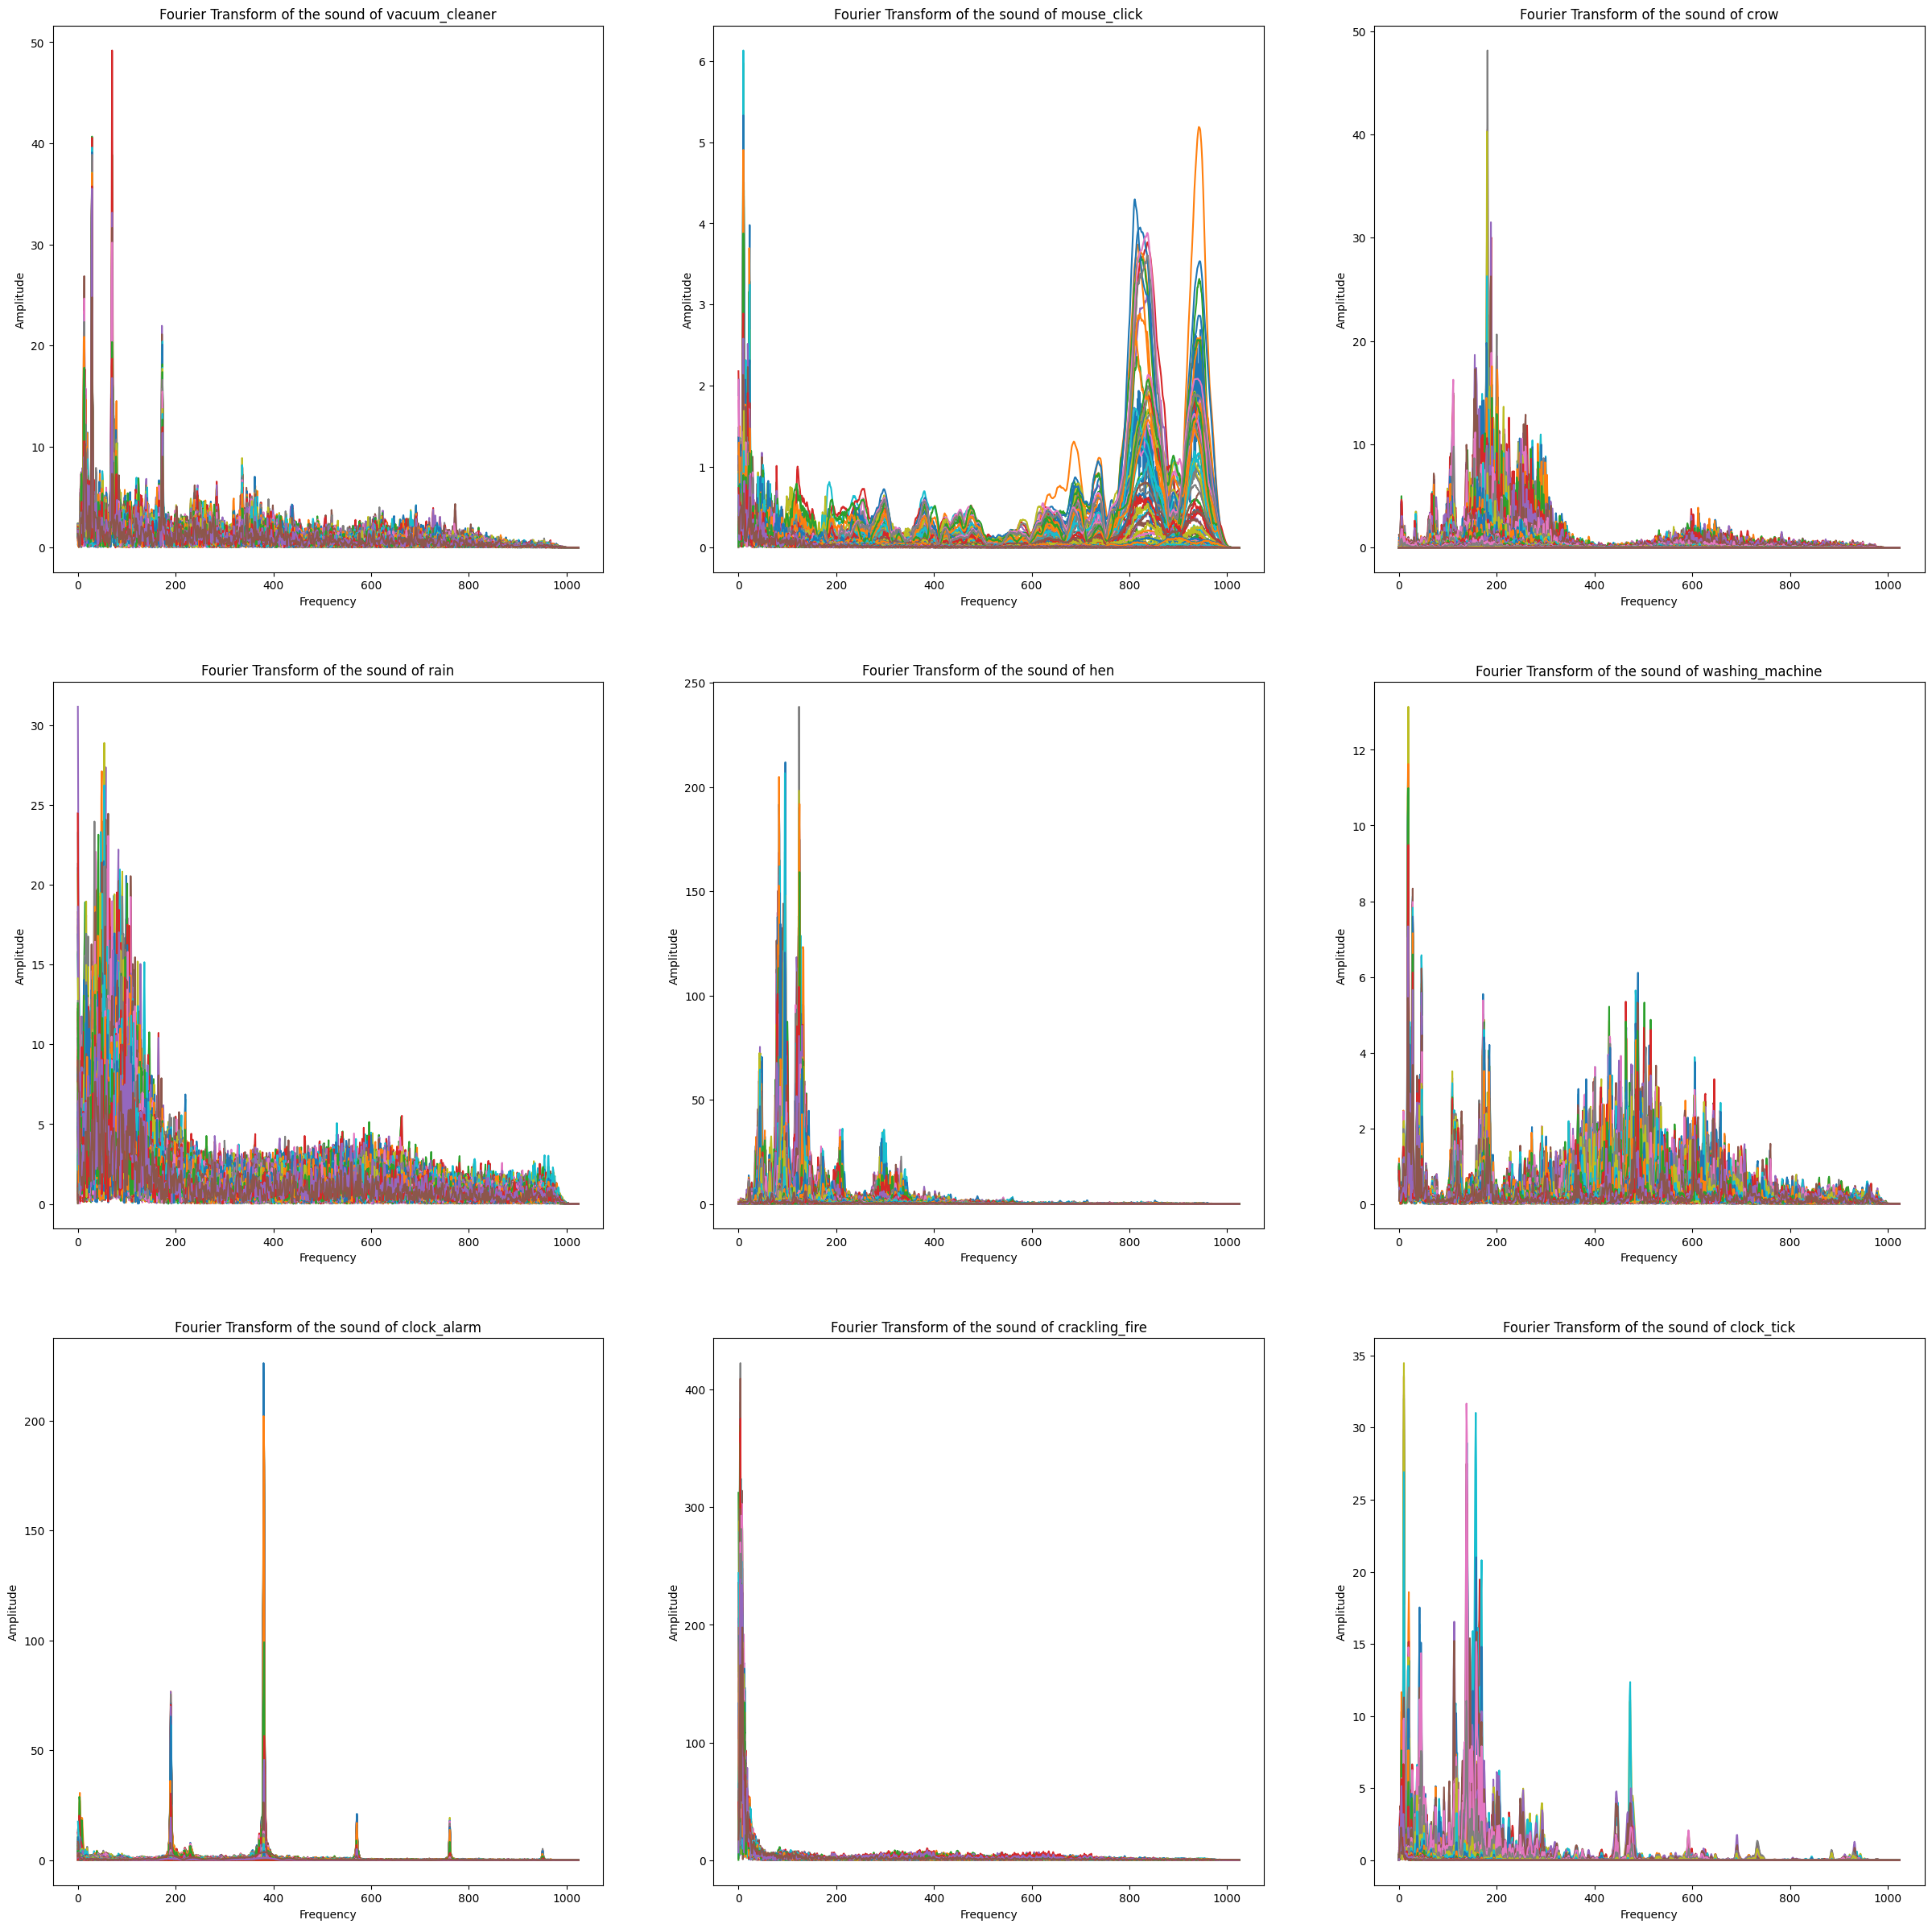

In [12]:
# default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns 

plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    X = np.abs(librosa.stft(plot_audios[i][0], n_fft = n_fft, hop_length = hop_length))
    plt.plot(X)
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude");
    try:
        plt.title("Fourier Transform of the sound of " + decoder[int(plot_files[i][-6:-4])] )
    except:
        plt.title("Fourier Transform of the sound of " + decoder[int(plot_files[i][-5:-4])] )


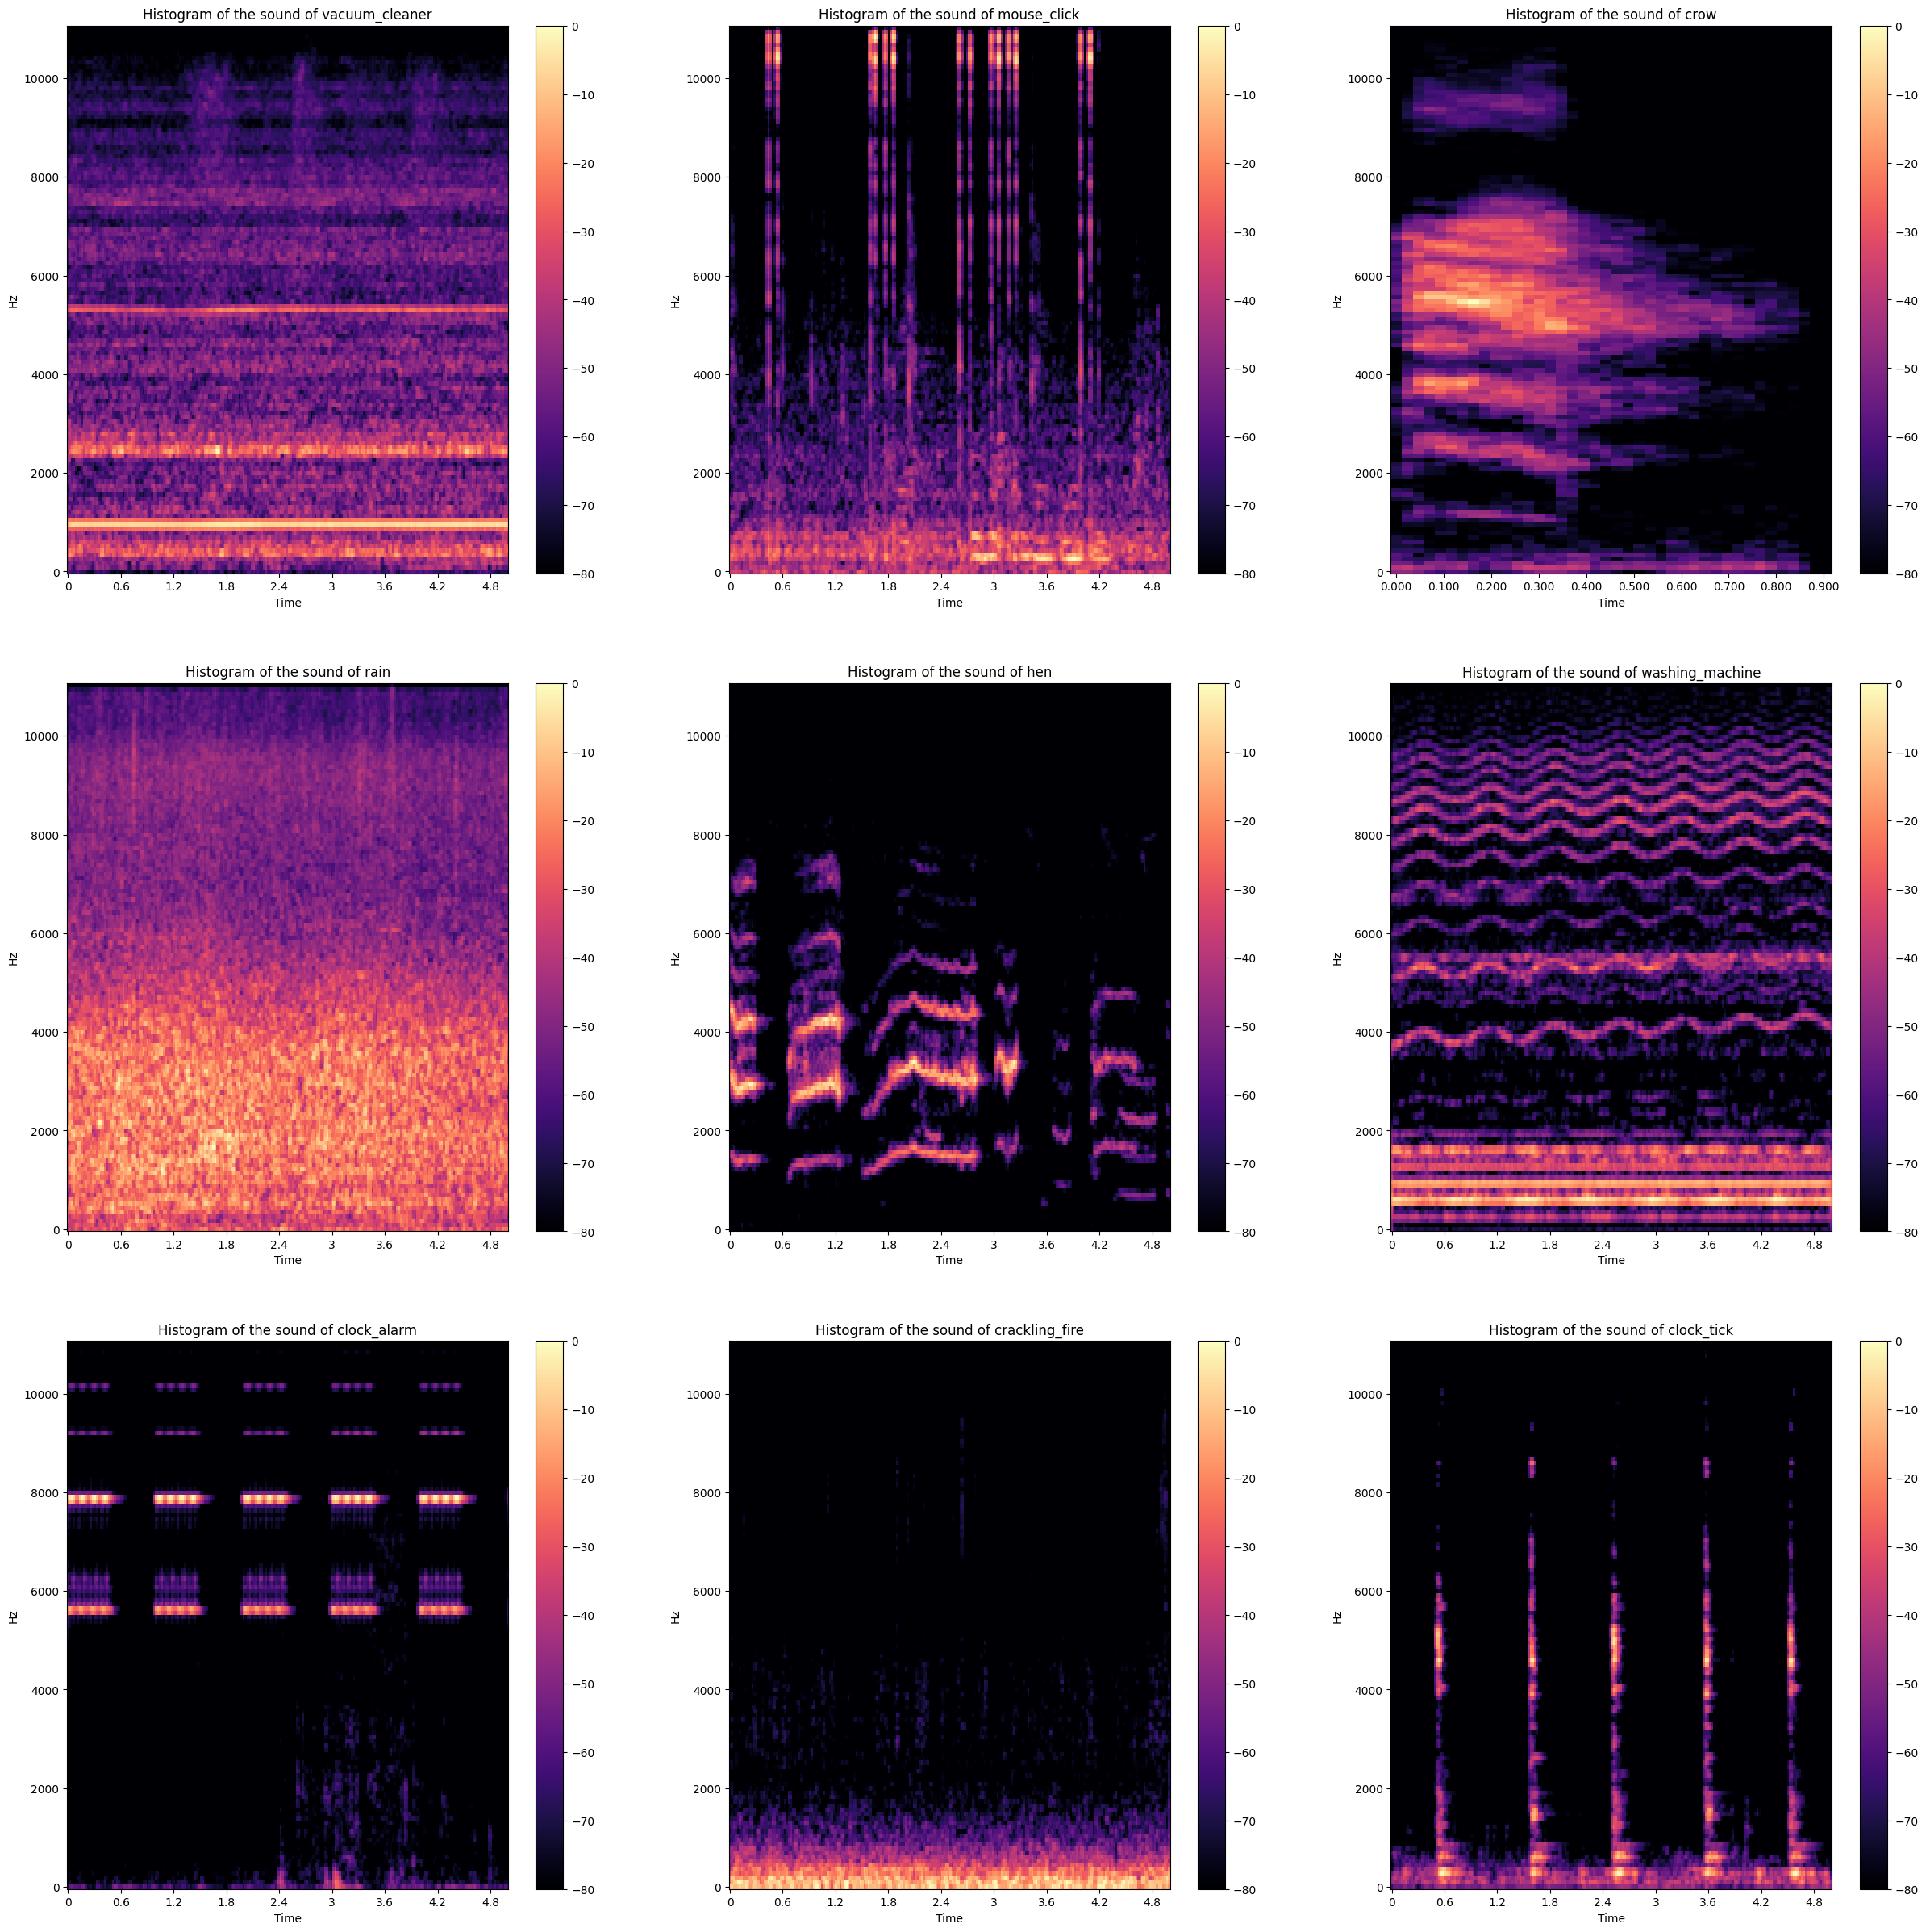

In [13]:
# mel-spectrogram representation 
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    X, _ = librosa.effects.trim(plot_audios[i][0])
    XS = librosa.feature.melspectrogram(y=X, sr=plot_audios[i][1])
    Xdb = librosa.amplitude_to_db(XS, ref=np.max)
    librosa.display.specshow(Xdb, sr=plot_audios[i][1], x_axis='time', y_axis='hz')
    plt.colorbar()
    try:
        plt.title("Histogram of the sound of " + decoder[int(plot_files[i][-6:-4])] )
    except:
        plt.title("Histogram of the sound of " + decoder[int(plot_files[i][-5:-4])] )

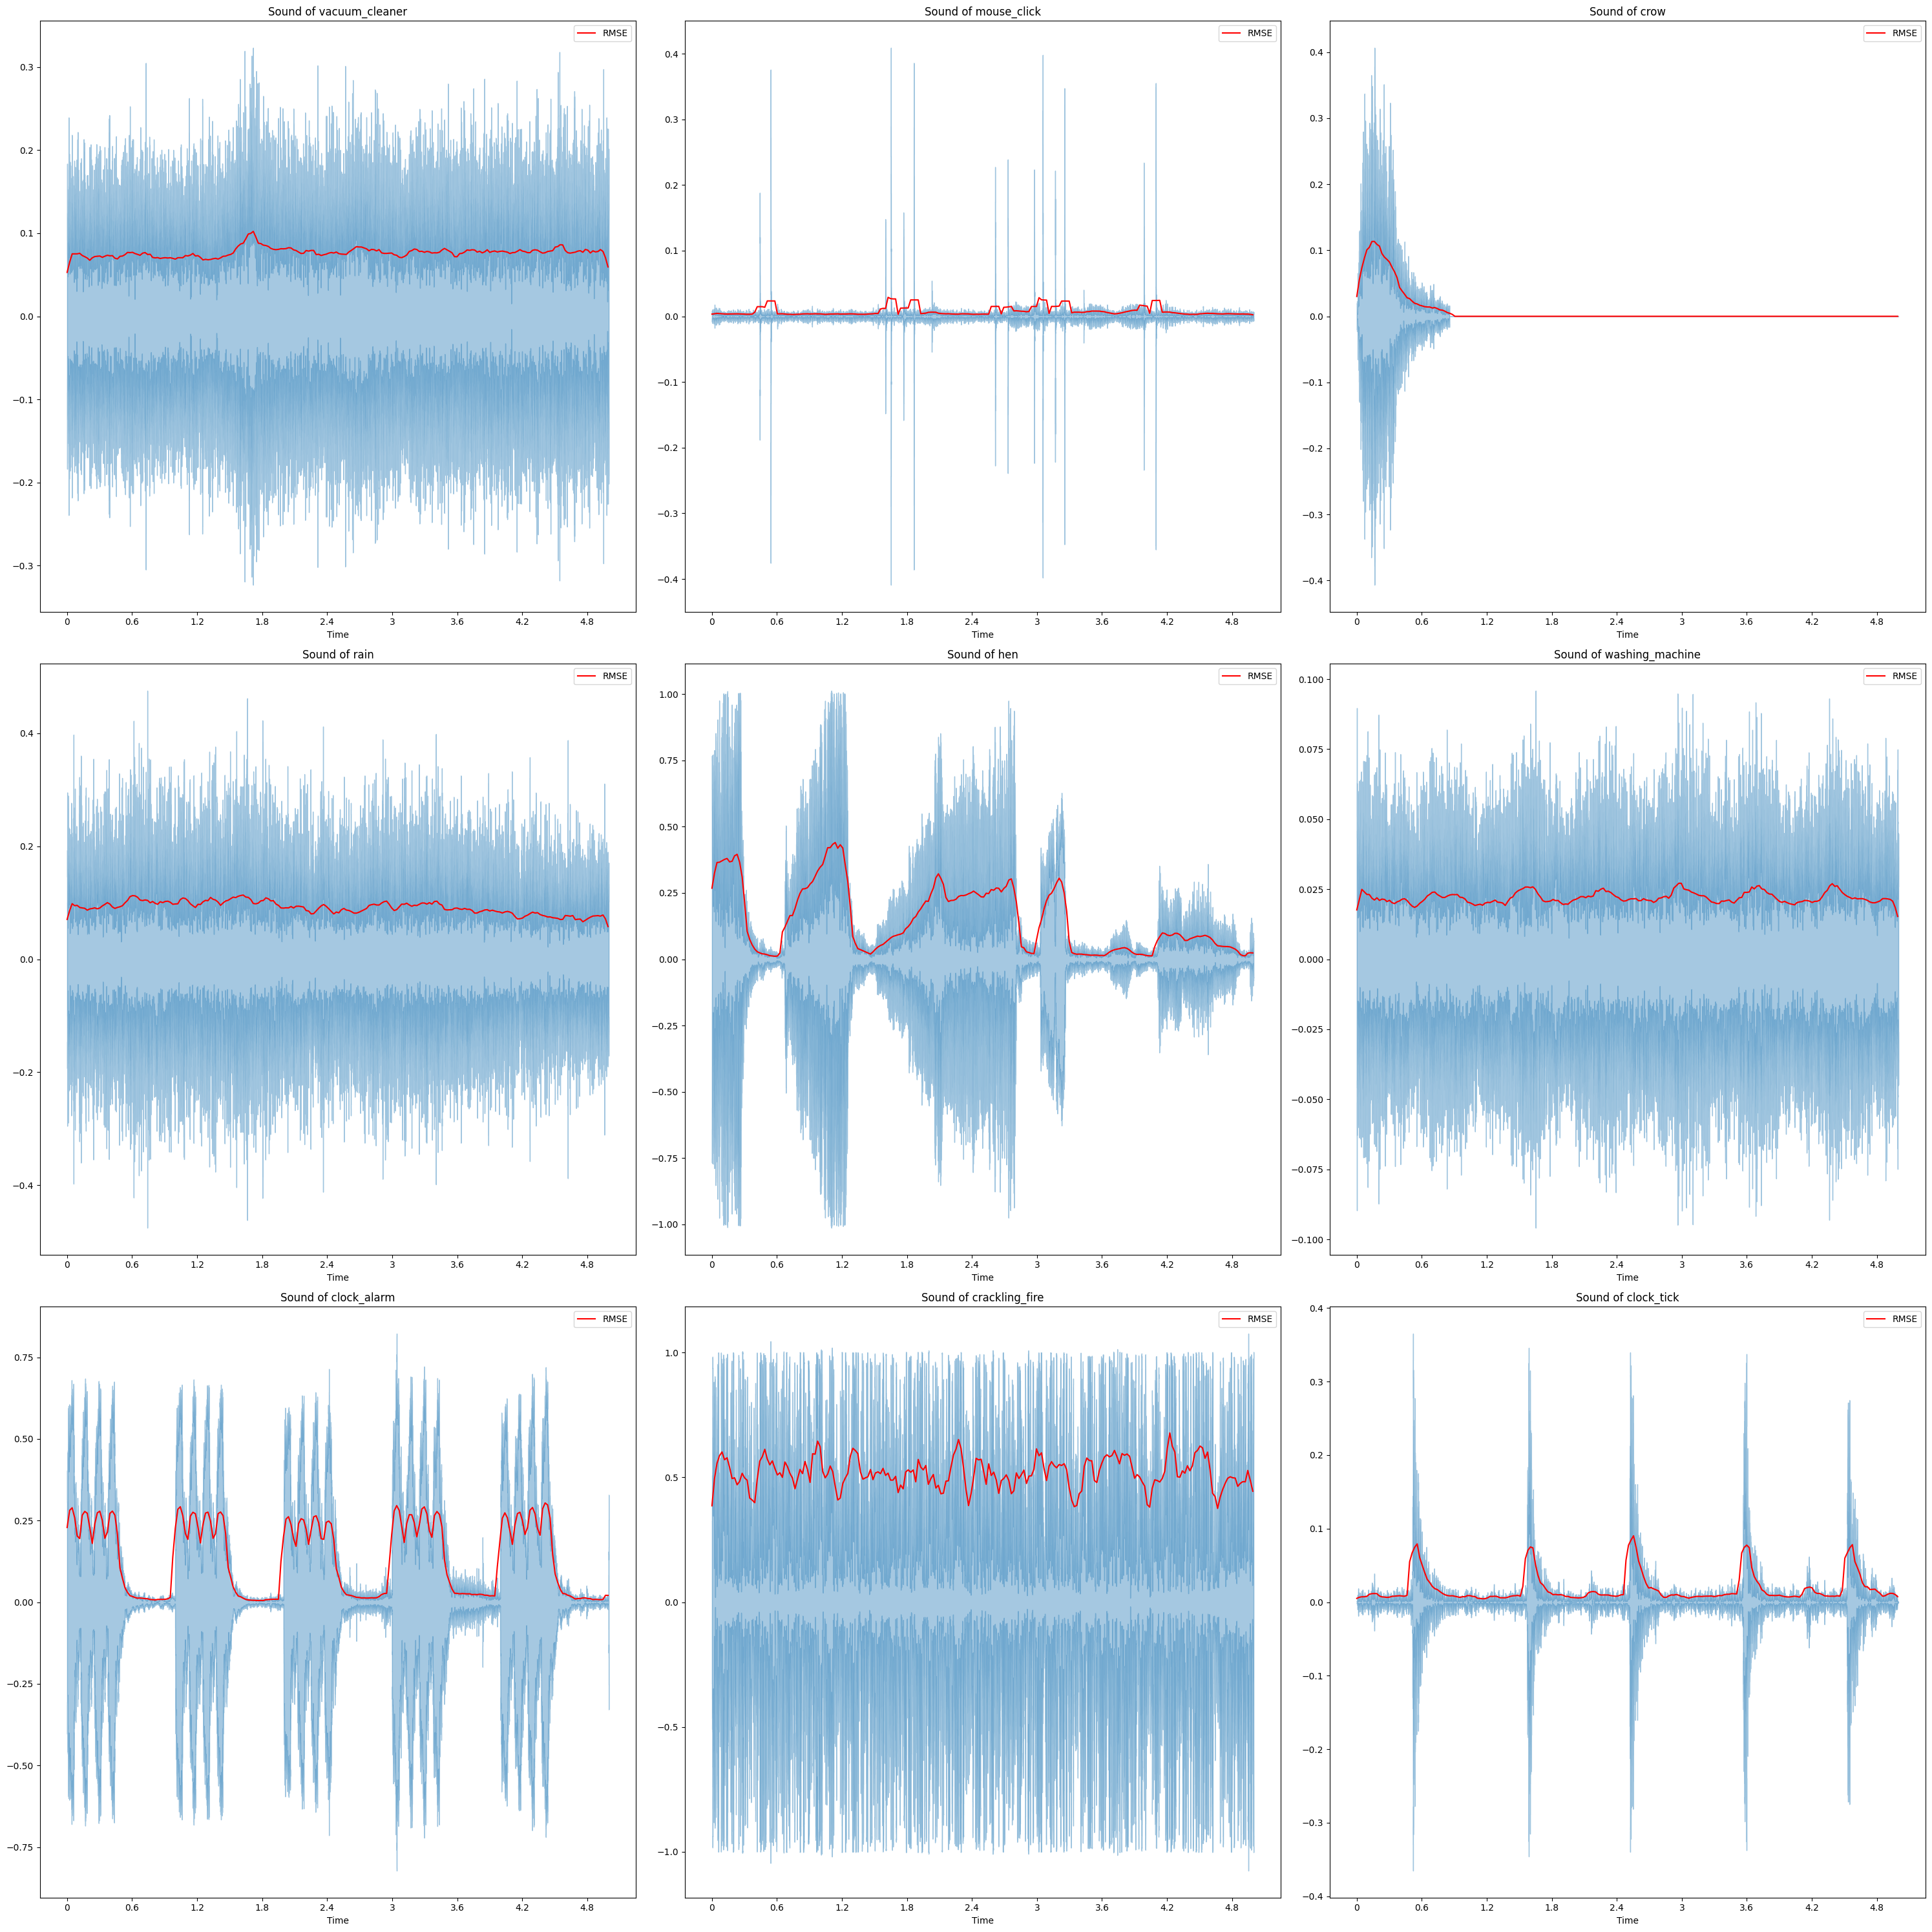

In [14]:
# visualize waveform
plt.figure(figsize=(30, 30))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    y = plot_audios[i][0]
    sr = plot_audios[i][1]

    # calculate RMSE 
    rmse = librosa.feature.rms(y=y)[0]

    # time axis 
    frames = range(len(rmse))
    t = librosa.frames_to_time(frames, sr=sr)

    # display waveform 
    librosa.display.waveshow(y, sr=sr, alpha=0.4)
    plt.plot(t, rmse, color='r', label="RMSE")

    try:
        plt.title("Sound of " + decoder[int(plot_files[i][-6:-4])])
    except:
        plt.title("Sound of " + decoder[int(plot_files[i][-5:-4])])
    
    plt.legend()

plt.tight_layout()
plt.show()

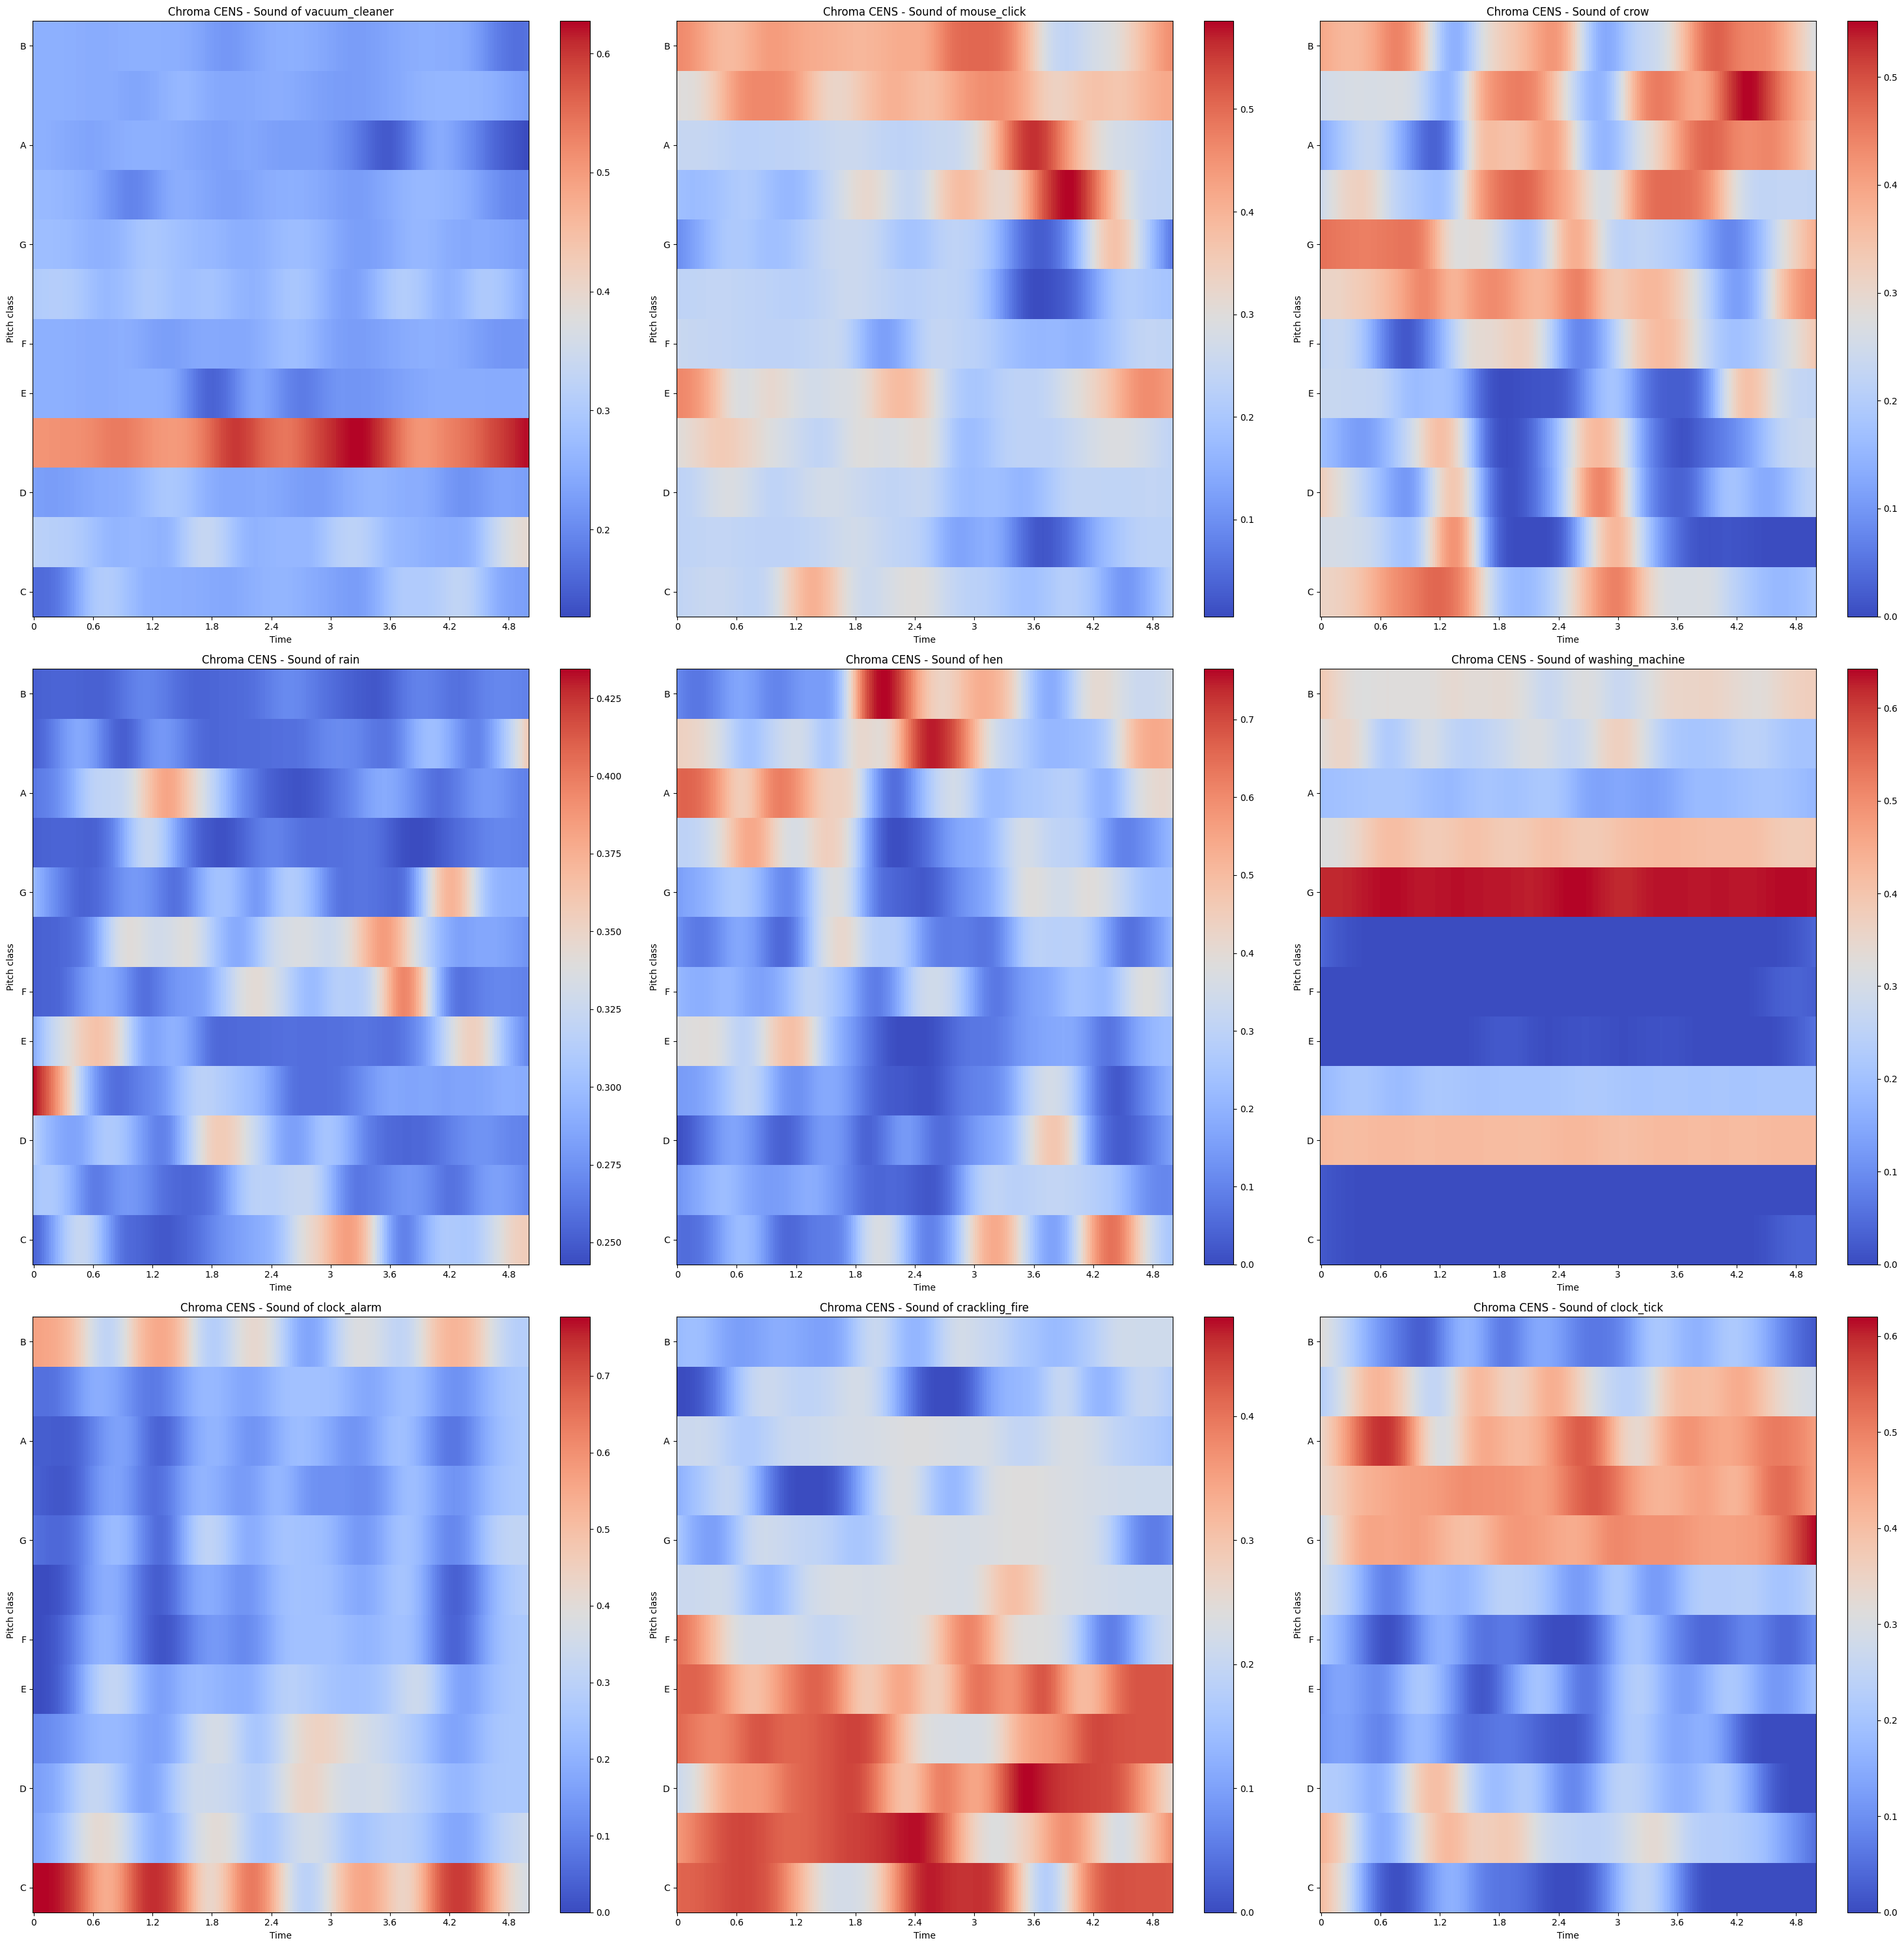

In [15]:
plt.figure(figsize=(30, 30))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    y = plot_audios[i][0]
    sr = plot_audios[i][1]

    # Tính toán chroma_cens
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)

    # Hiển thị chroma_cens bằng specshow
    librosa.display.specshow(chroma_cens, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')

    try:
        plt.title("Chroma CENS - Sound of " + decoder[int(plot_files[i][-6:-4])])
    except:
        plt.title("Chroma CENS - Sound of " + decoder[int(plot_files[i][-5:-4])])

    plt.colorbar()

plt.tight_layout()
plt.show()

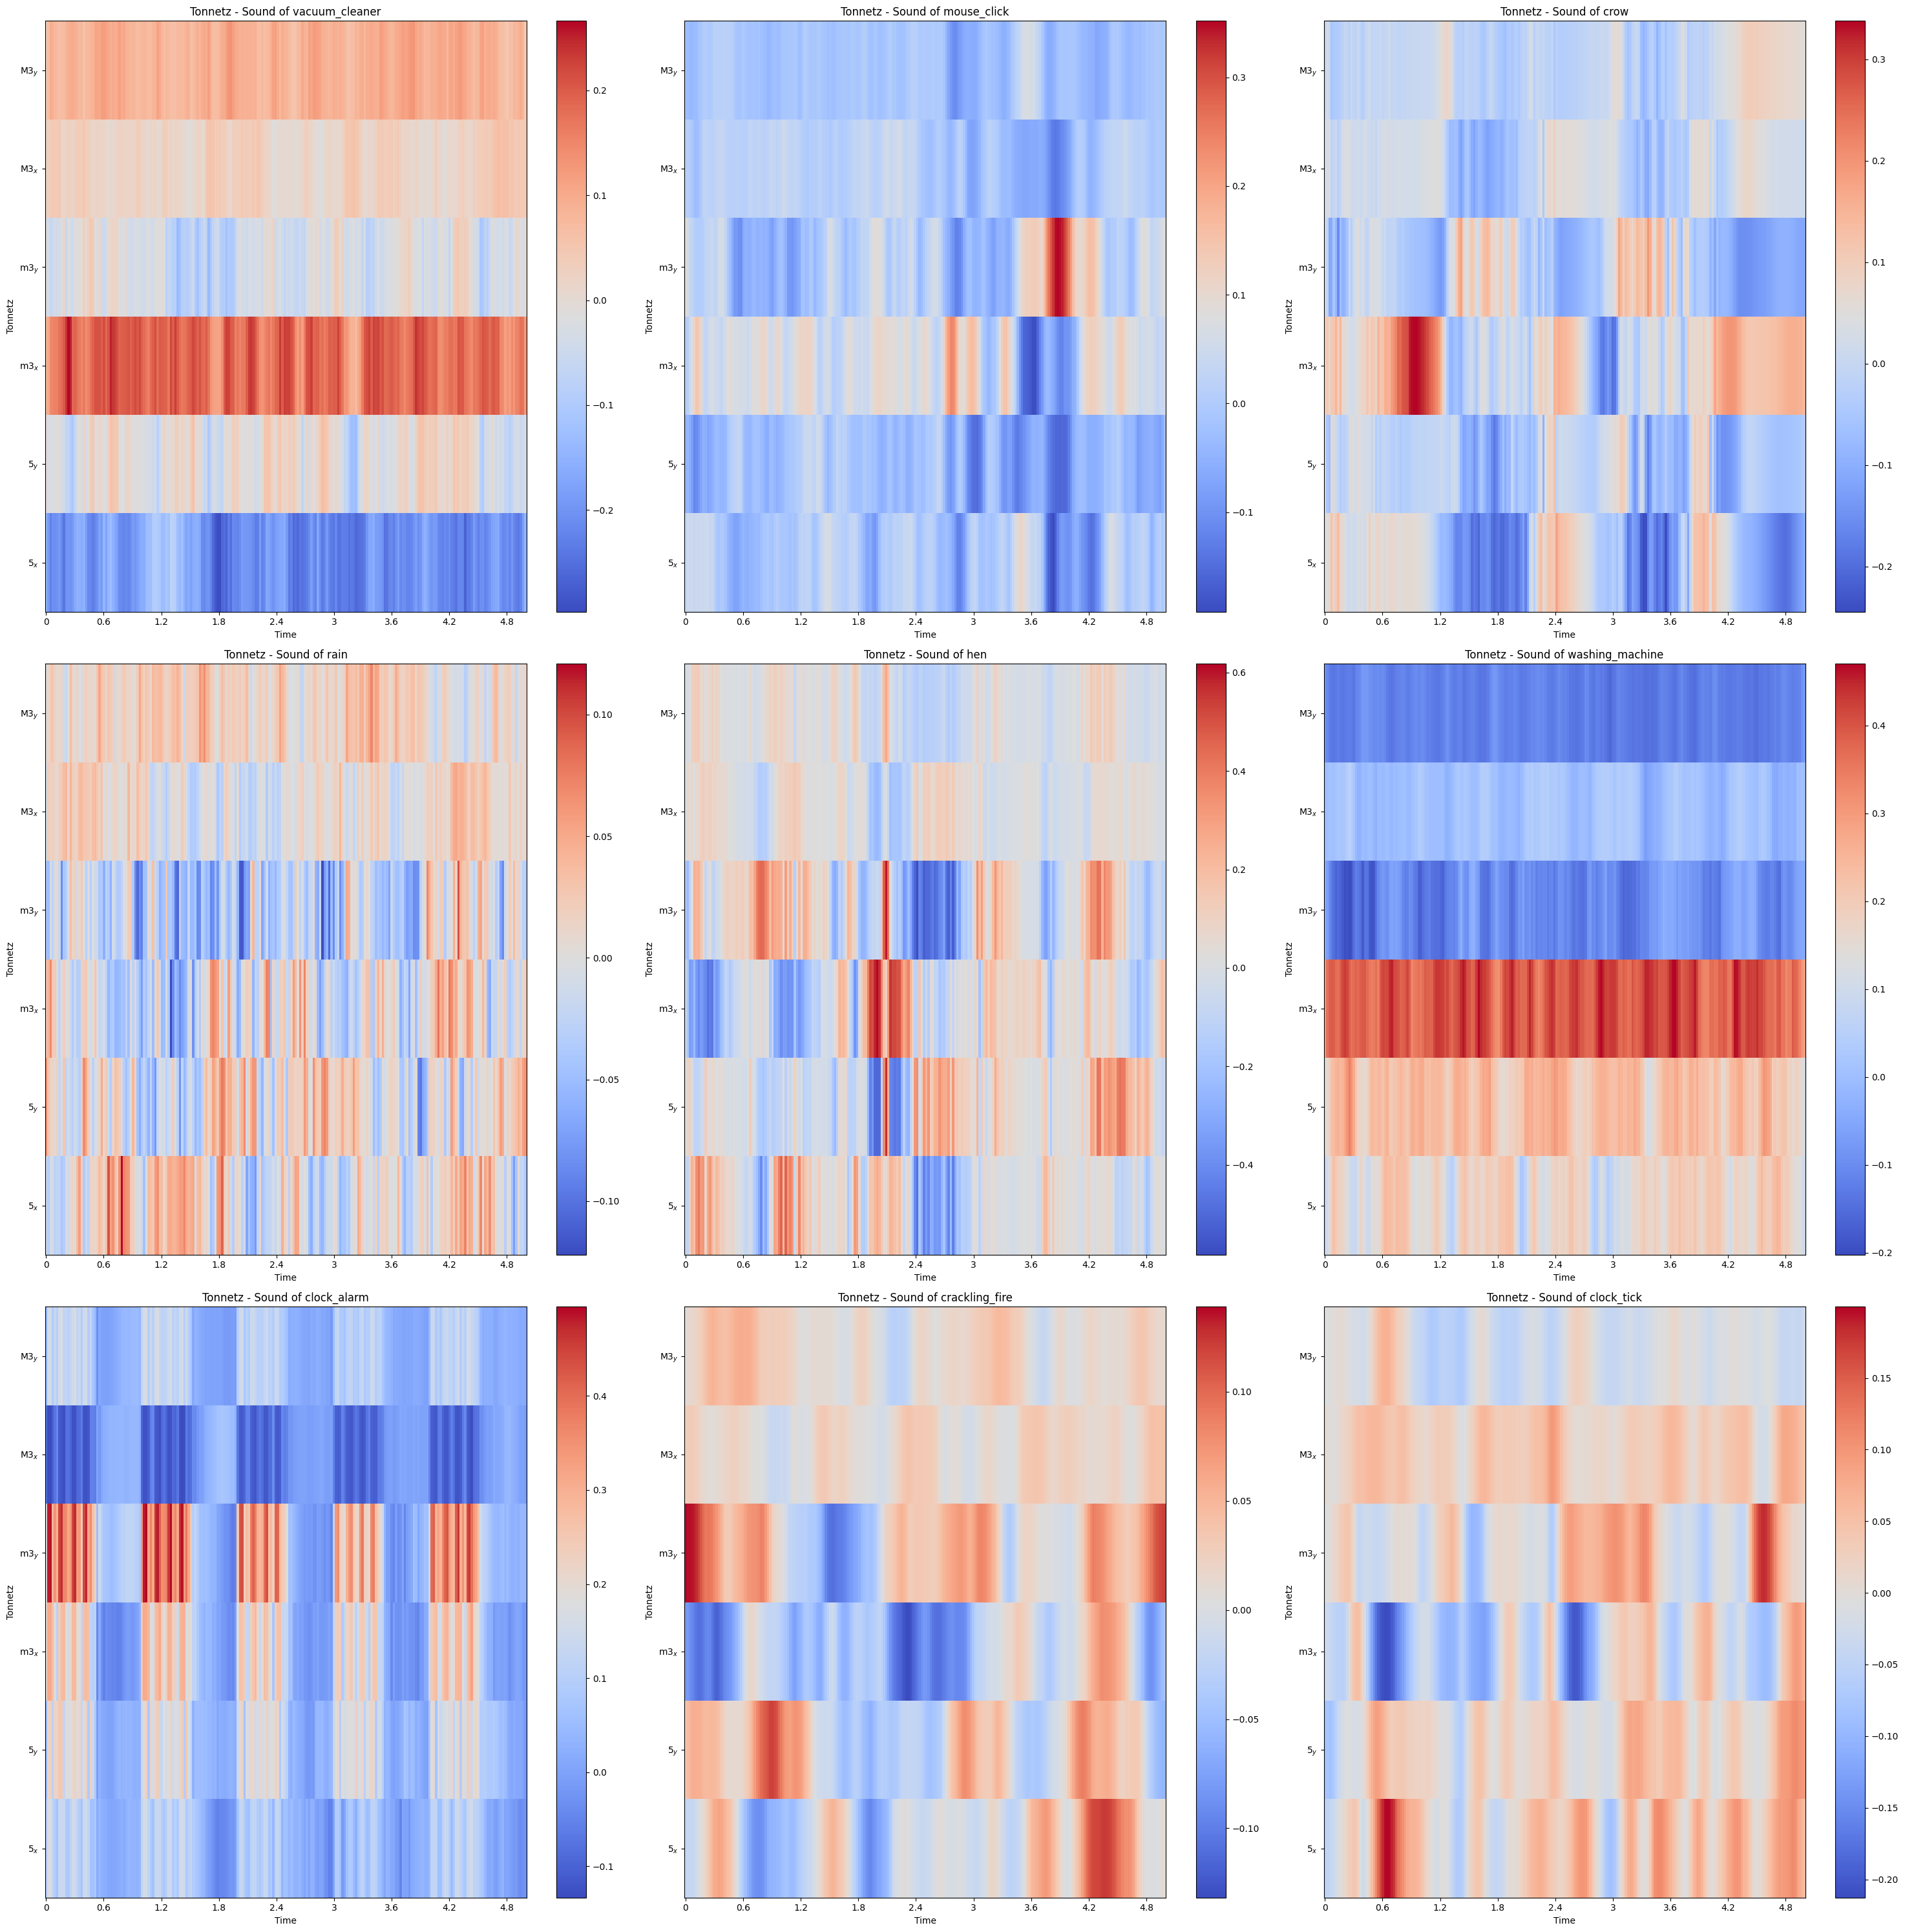

In [16]:
plt.figure(figsize=(30, 30))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    y = plot_audios[i][0]
    sr = plot_audios[i][1]

    # Tính toán tonnetz
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

    # Hiển thị tonnetz bằng specshow
    librosa.display.specshow(tonnetz, sr=sr, x_axis='time', y_axis='tonnetz', cmap='coolwarm')

    try:
        plt.title("Tonnetz - Sound of " + decoder[int(plot_files[i][-6:-4])])
    except:
        plt.title("Tonnetz - Sound of " + decoder[int(plot_files[i][-5:-4])])

    plt.colorbar()

plt.tight_layout()
plt.show()

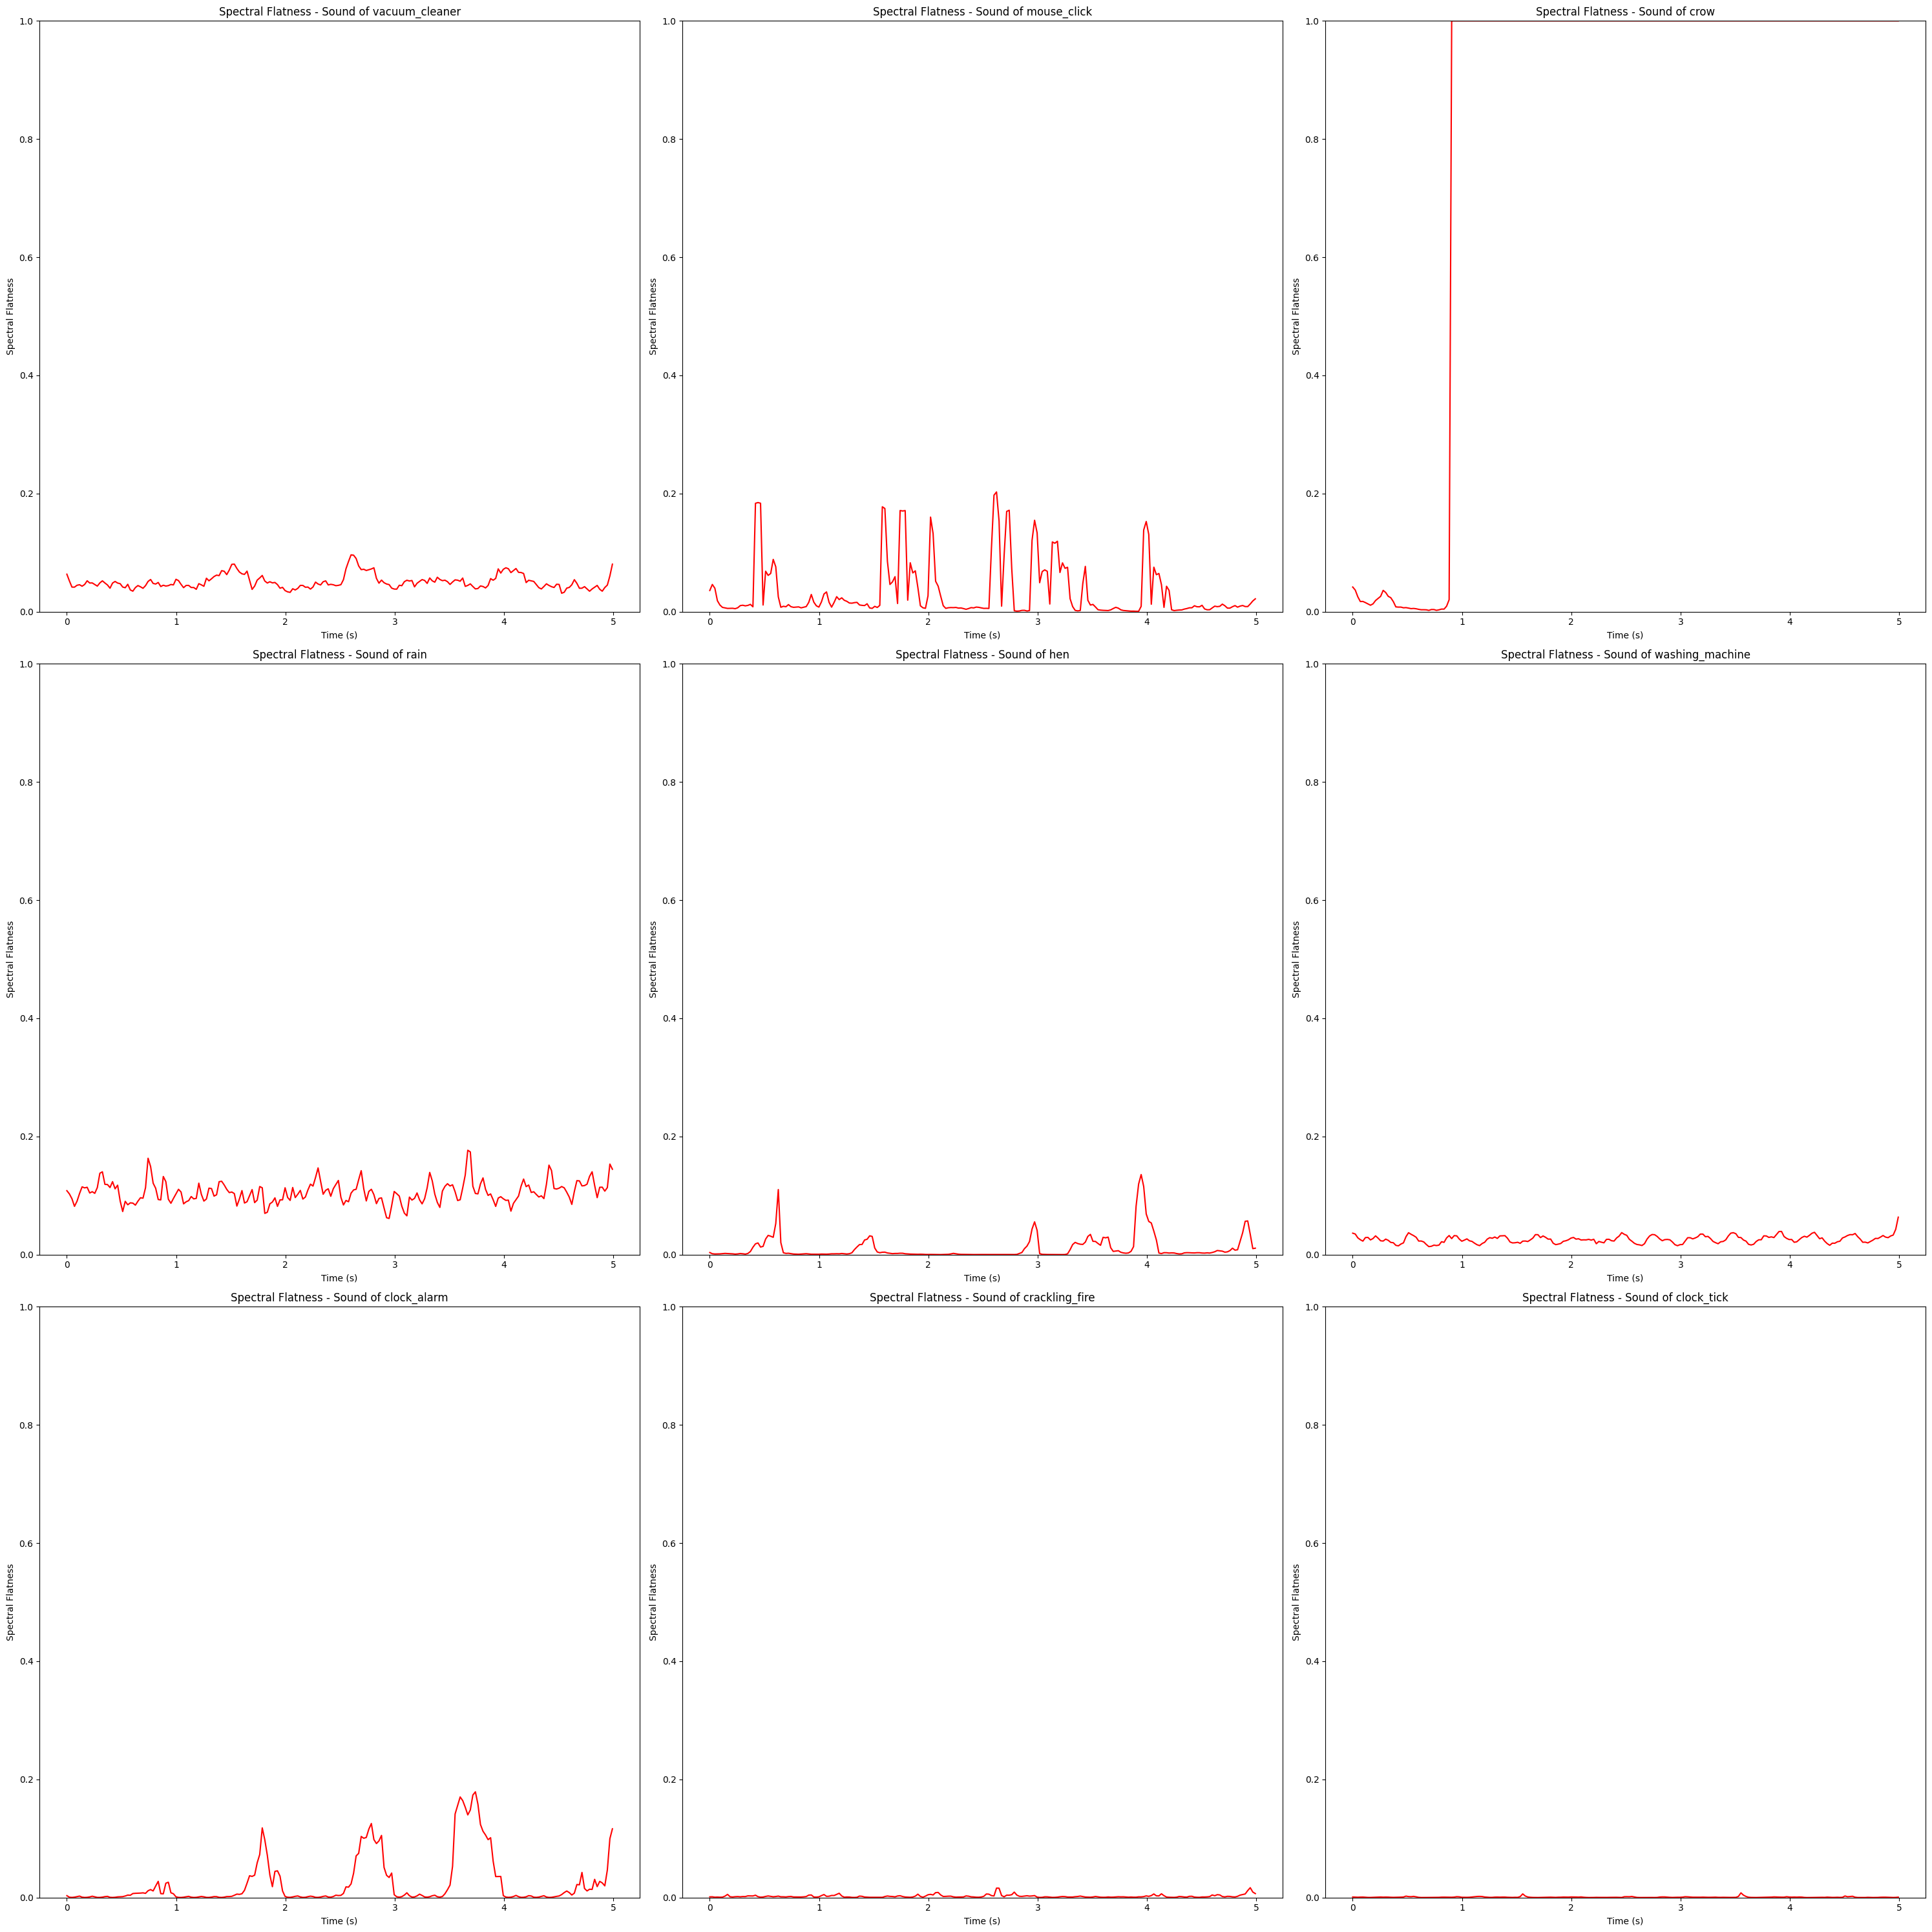

In [17]:
plt.figure(figsize=(30, 30))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    y = plot_audios[i][0]
    sr = plot_audios[i][1]

    # Tính toán Spectral Flatness
    spectral_flatness = librosa.feature.spectral_flatness(y=y)

    # Trục thời gian
    frames = range(len(spectral_flatness[0]))
    t = librosa.frames_to_time(frames, sr=sr)

    # Vẽ biểu đồ Spectral Flatness
    plt.plot(t, spectral_flatness[0], color='r')
    plt.xlabel("Time (s)")
    plt.ylabel("Spectral Flatness")
    plt.ylim(0, 1)  # Giá trị Spectral Flatness nằm trong khoảng 0-1

    try:
        plt.title("Spectral Flatness - Sound of " + decoder[int(plot_files[i][-6:-4])])
    except:
        plt.title("Spectral Flatness - Sound of " + decoder[int(plot_files[i][-5:-4])])

plt.tight_layout()
plt.show()


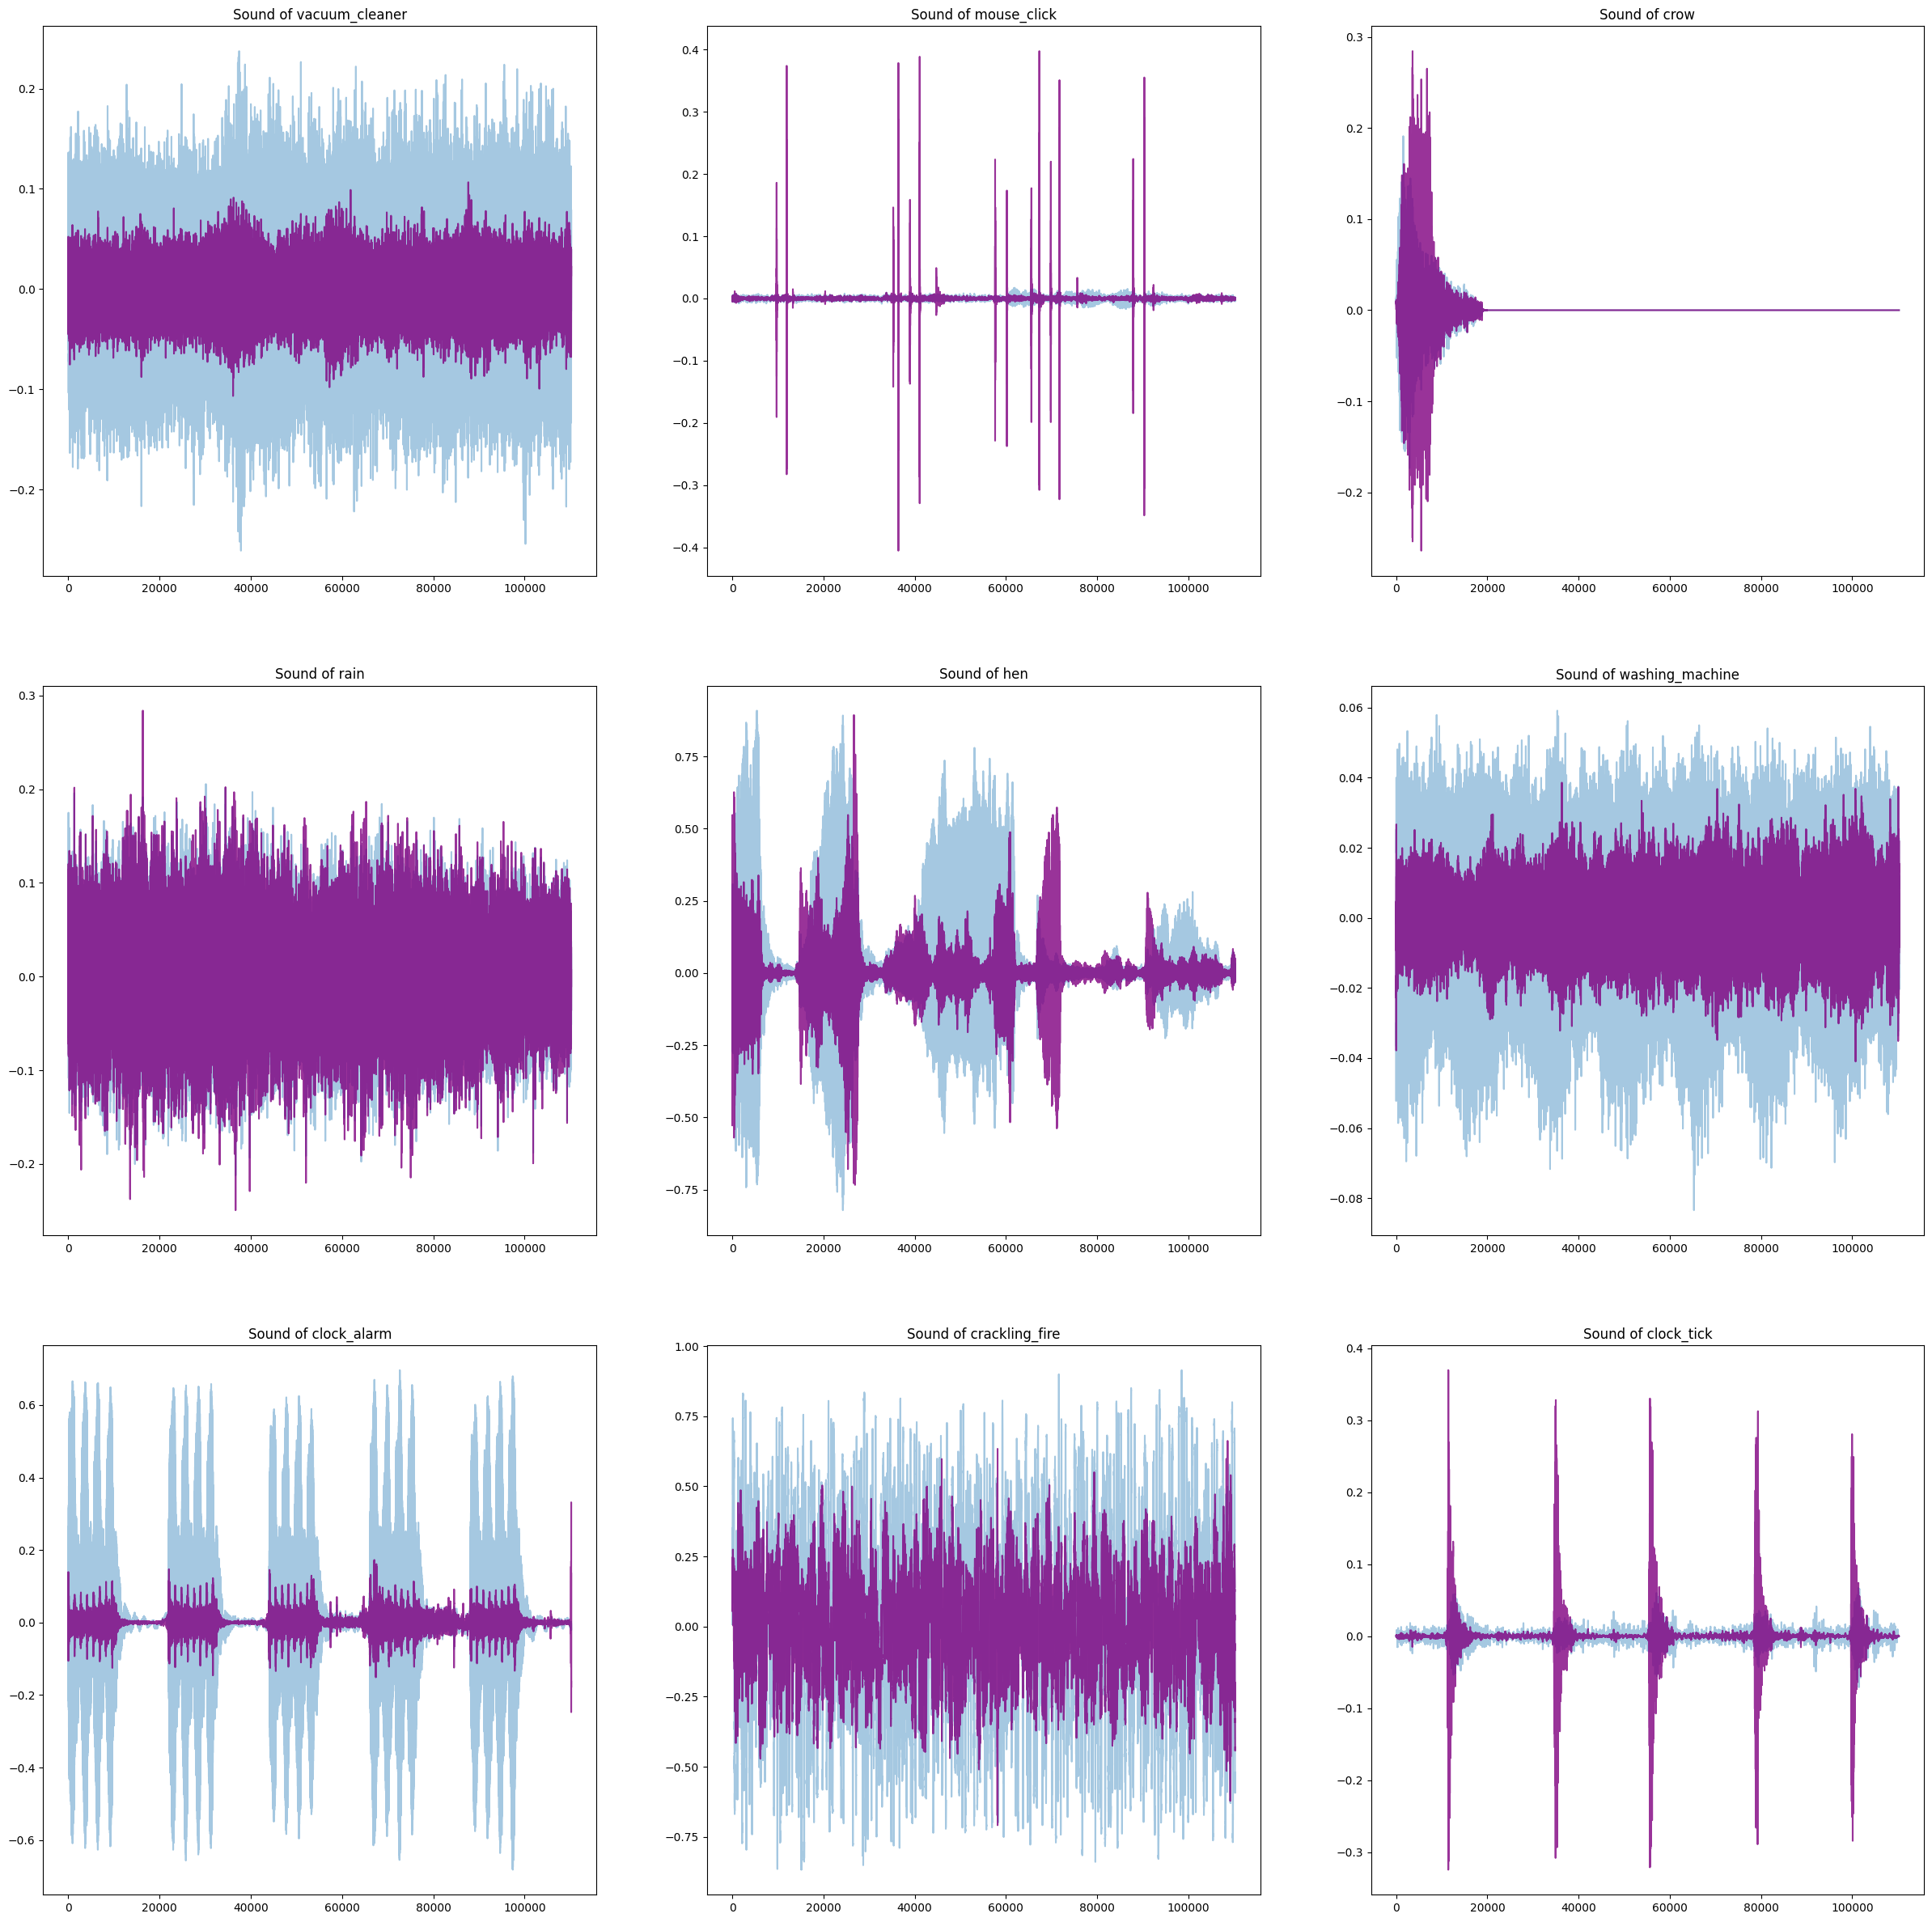

In [18]:
"""
This script uses Harmonic-Percussive Source Separation (HPSS) in librosa to decompose an audio signal into 
harmonic and percussive components, then visualizes them using waveform plots."
"""
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    y_harm, y_perc = librosa.effects.hpss(plot_audios[i][0])
    plt.plot(y_harm, alpha=0.4);
    plt.plot(y_perc, color = 'purple', alpha=0.8);
    try:
        plt.title("Sound of " + decoder[int(plot_files[i][-6:-4])] )
    except:
        plt.title("Sound of " + decoder[int(plot_files[i][-5:-4])] )

In [19]:
for i in range(1,10):
    tempo, _ = librosa.beat.beat_track(y=plot_audios[i][0], sr=plot_audios[i][1])
    
    file_path = plot_files[i]  # Đường dẫn gốc
    try:
        sound_label = decoder[int(plot_files[i][-6:-4])]
    except:
        sound_label = decoder[int(plot_files[i][-5:-4])]

    print('File path : ', file_path)
    print('Sound of ' + sound_label)
    print('BPM :', tempo)
    print('--------------------------')


File path :  ESC-50-master/audio\1-19872-B-36.wav
Sound of vacuum_cleaner
BPM : [86.1328125]
--------------------------
File path :  ESC-50-master/audio\3-167096-A-31.wav
Sound of mouse_click
BPM : [135.99917763]
--------------------------
File path :  ESC-50-master/audio\3-124925-A-9.wav
Sound of crow
BPM : [287.109375]
--------------------------
File path :  ESC-50-master/resample\3-142006-A-10.wav
Sound of rain
BPM : [107.66601562]
--------------------------
File path :  ESC-50-master/resample\2-72268-A-6.wav
Sound of hen
BPM : [117.45383523]
--------------------------
File path :  ESC-50-master/resample\4-218199-H-35.wav
Sound of washing_machine
BPM : [129.19921875]
--------------------------
File path :  ESC-50-master/audio\1-74517-A-37.wav
Sound of clock_alarm
BPM : [60.09265988]
--------------------------
File path :  ESC-50-master/audio\5-186924-A-12.wav
Sound of crackling_fire
BPM : [112.34714674]
--------------------------
File path :  ESC-50-master/audio\1-21934-A-38.wav
Sou

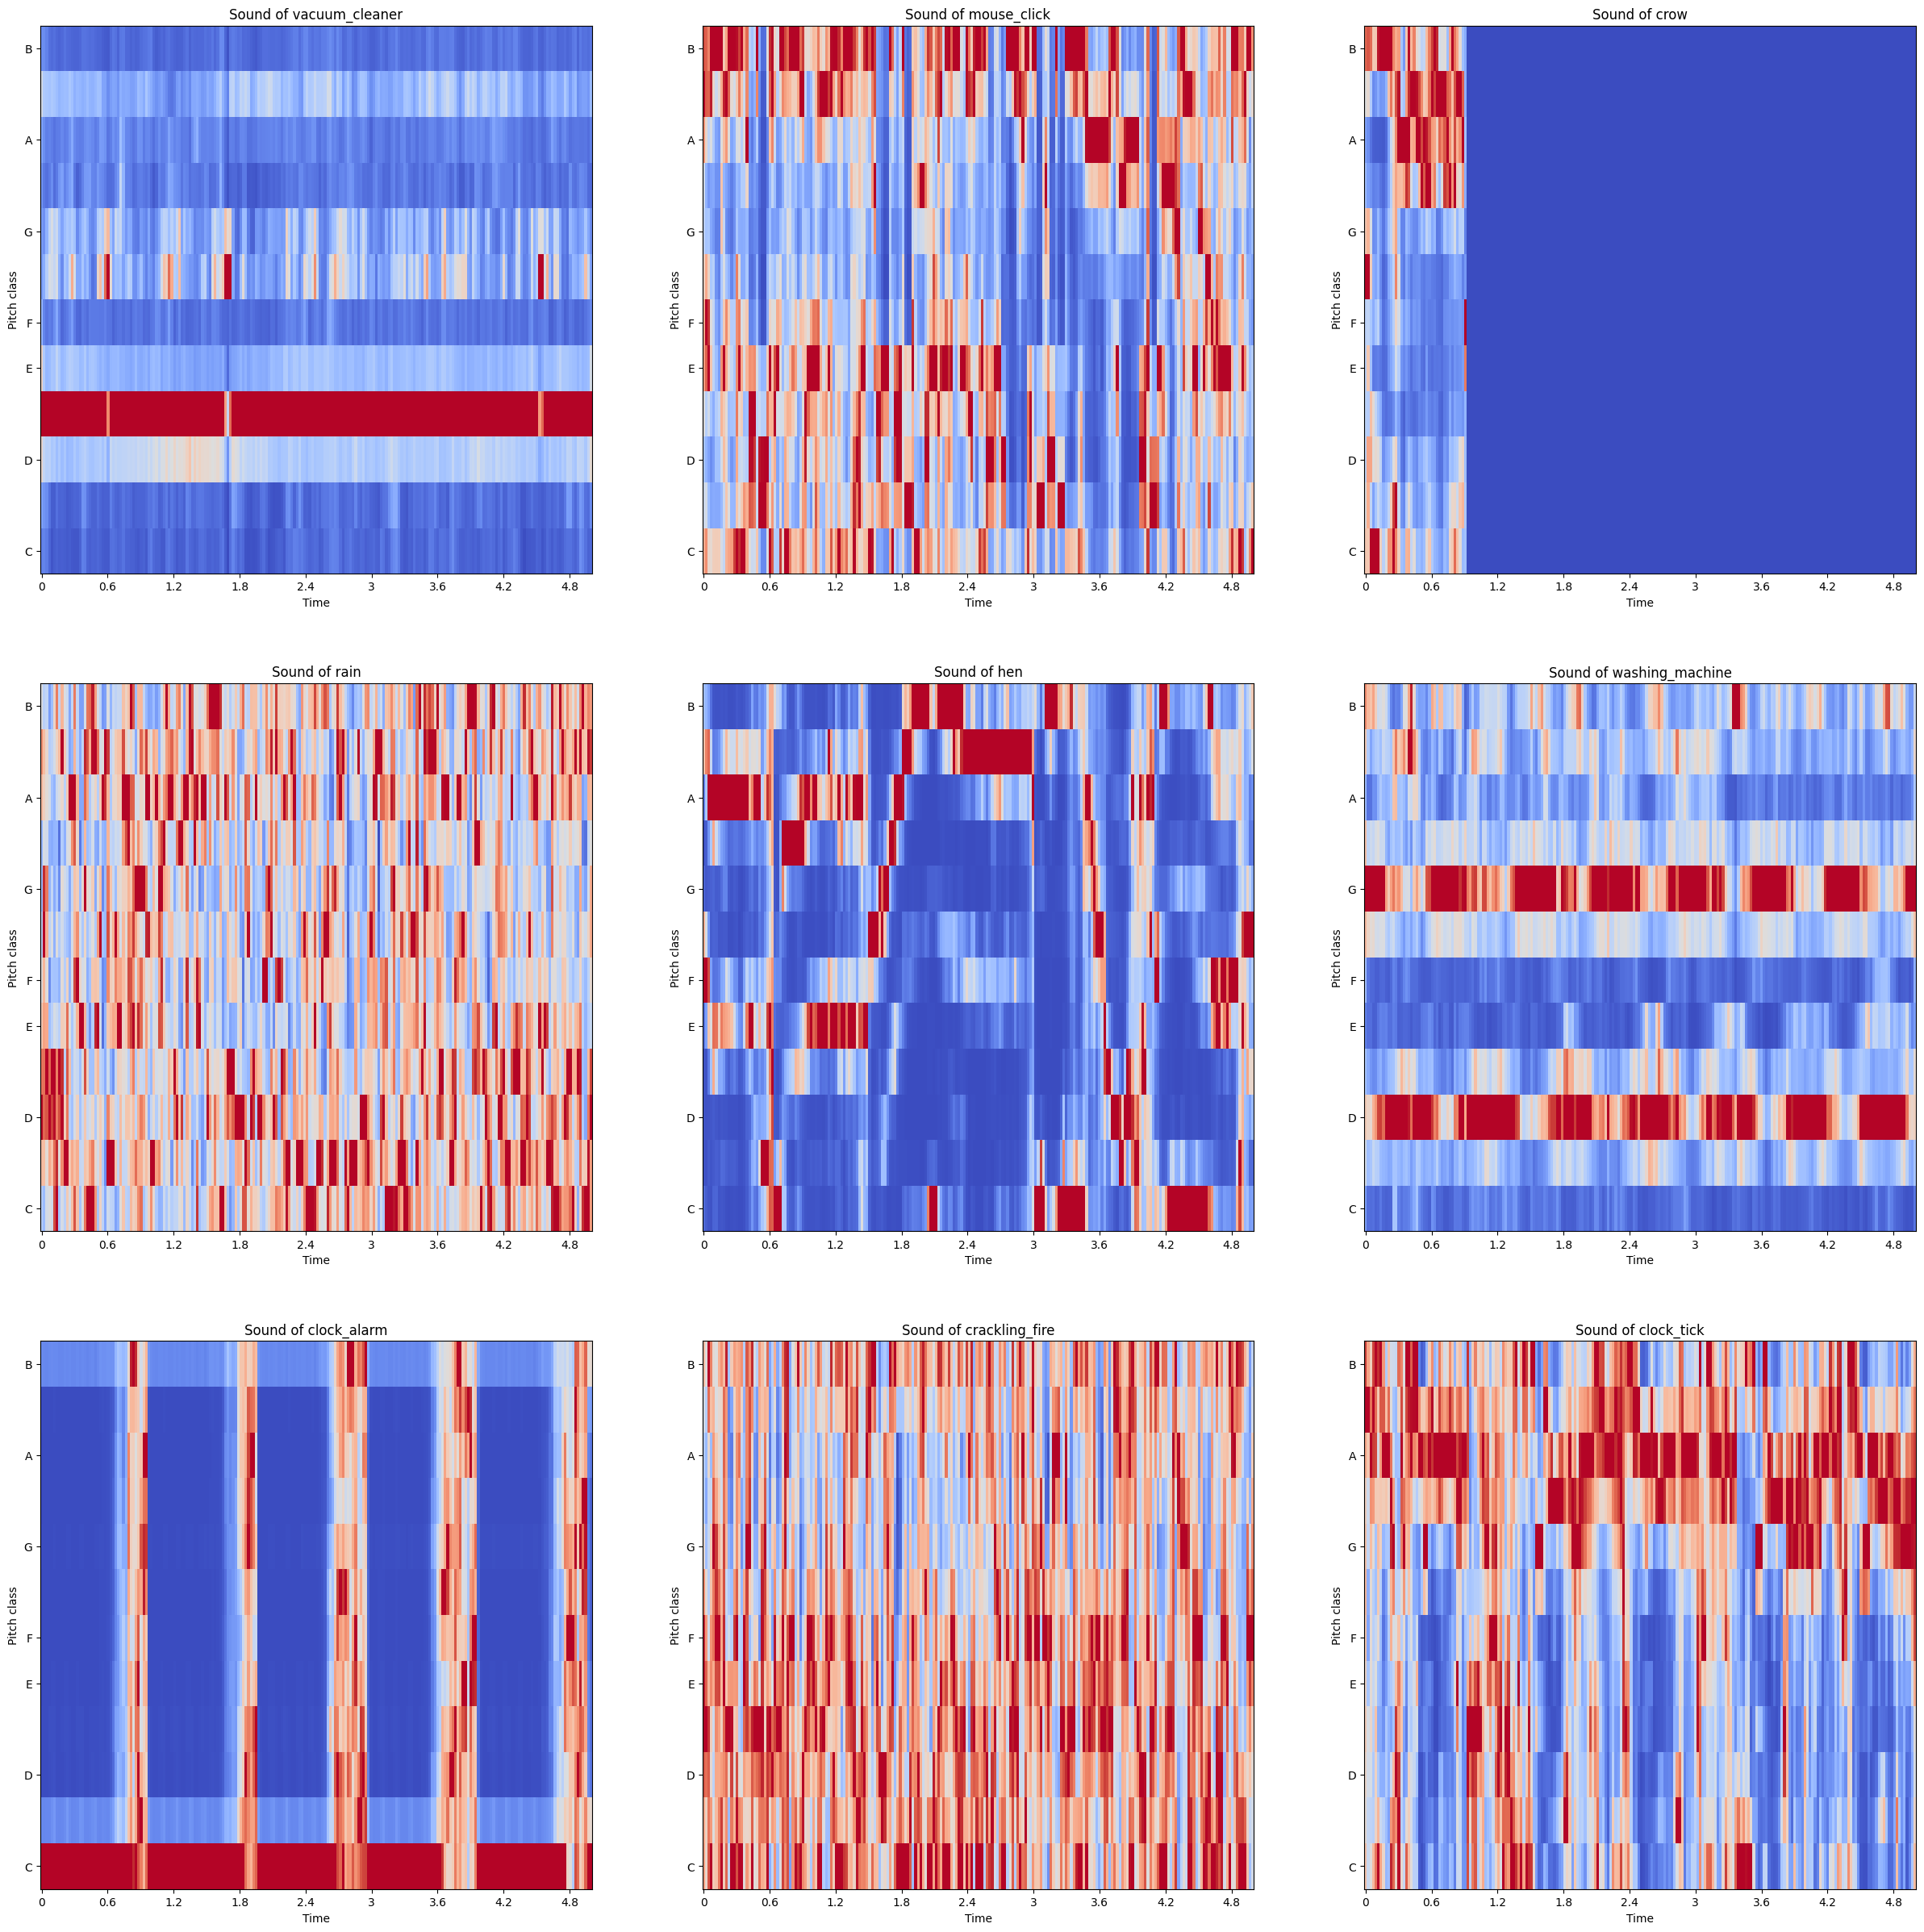

In [20]:
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    chromagram = librosa.feature.chroma_stft(y=plot_audios[i][0], sr=plot_audios[i][1], hop_length=hop_length)
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    try:
        plt.title("Sound of " + decoder[int(plot_files[i][-6:-4])] )
    except:
        plt.title("Sound of " + decoder[int(plot_files[i][-5:-4])] )

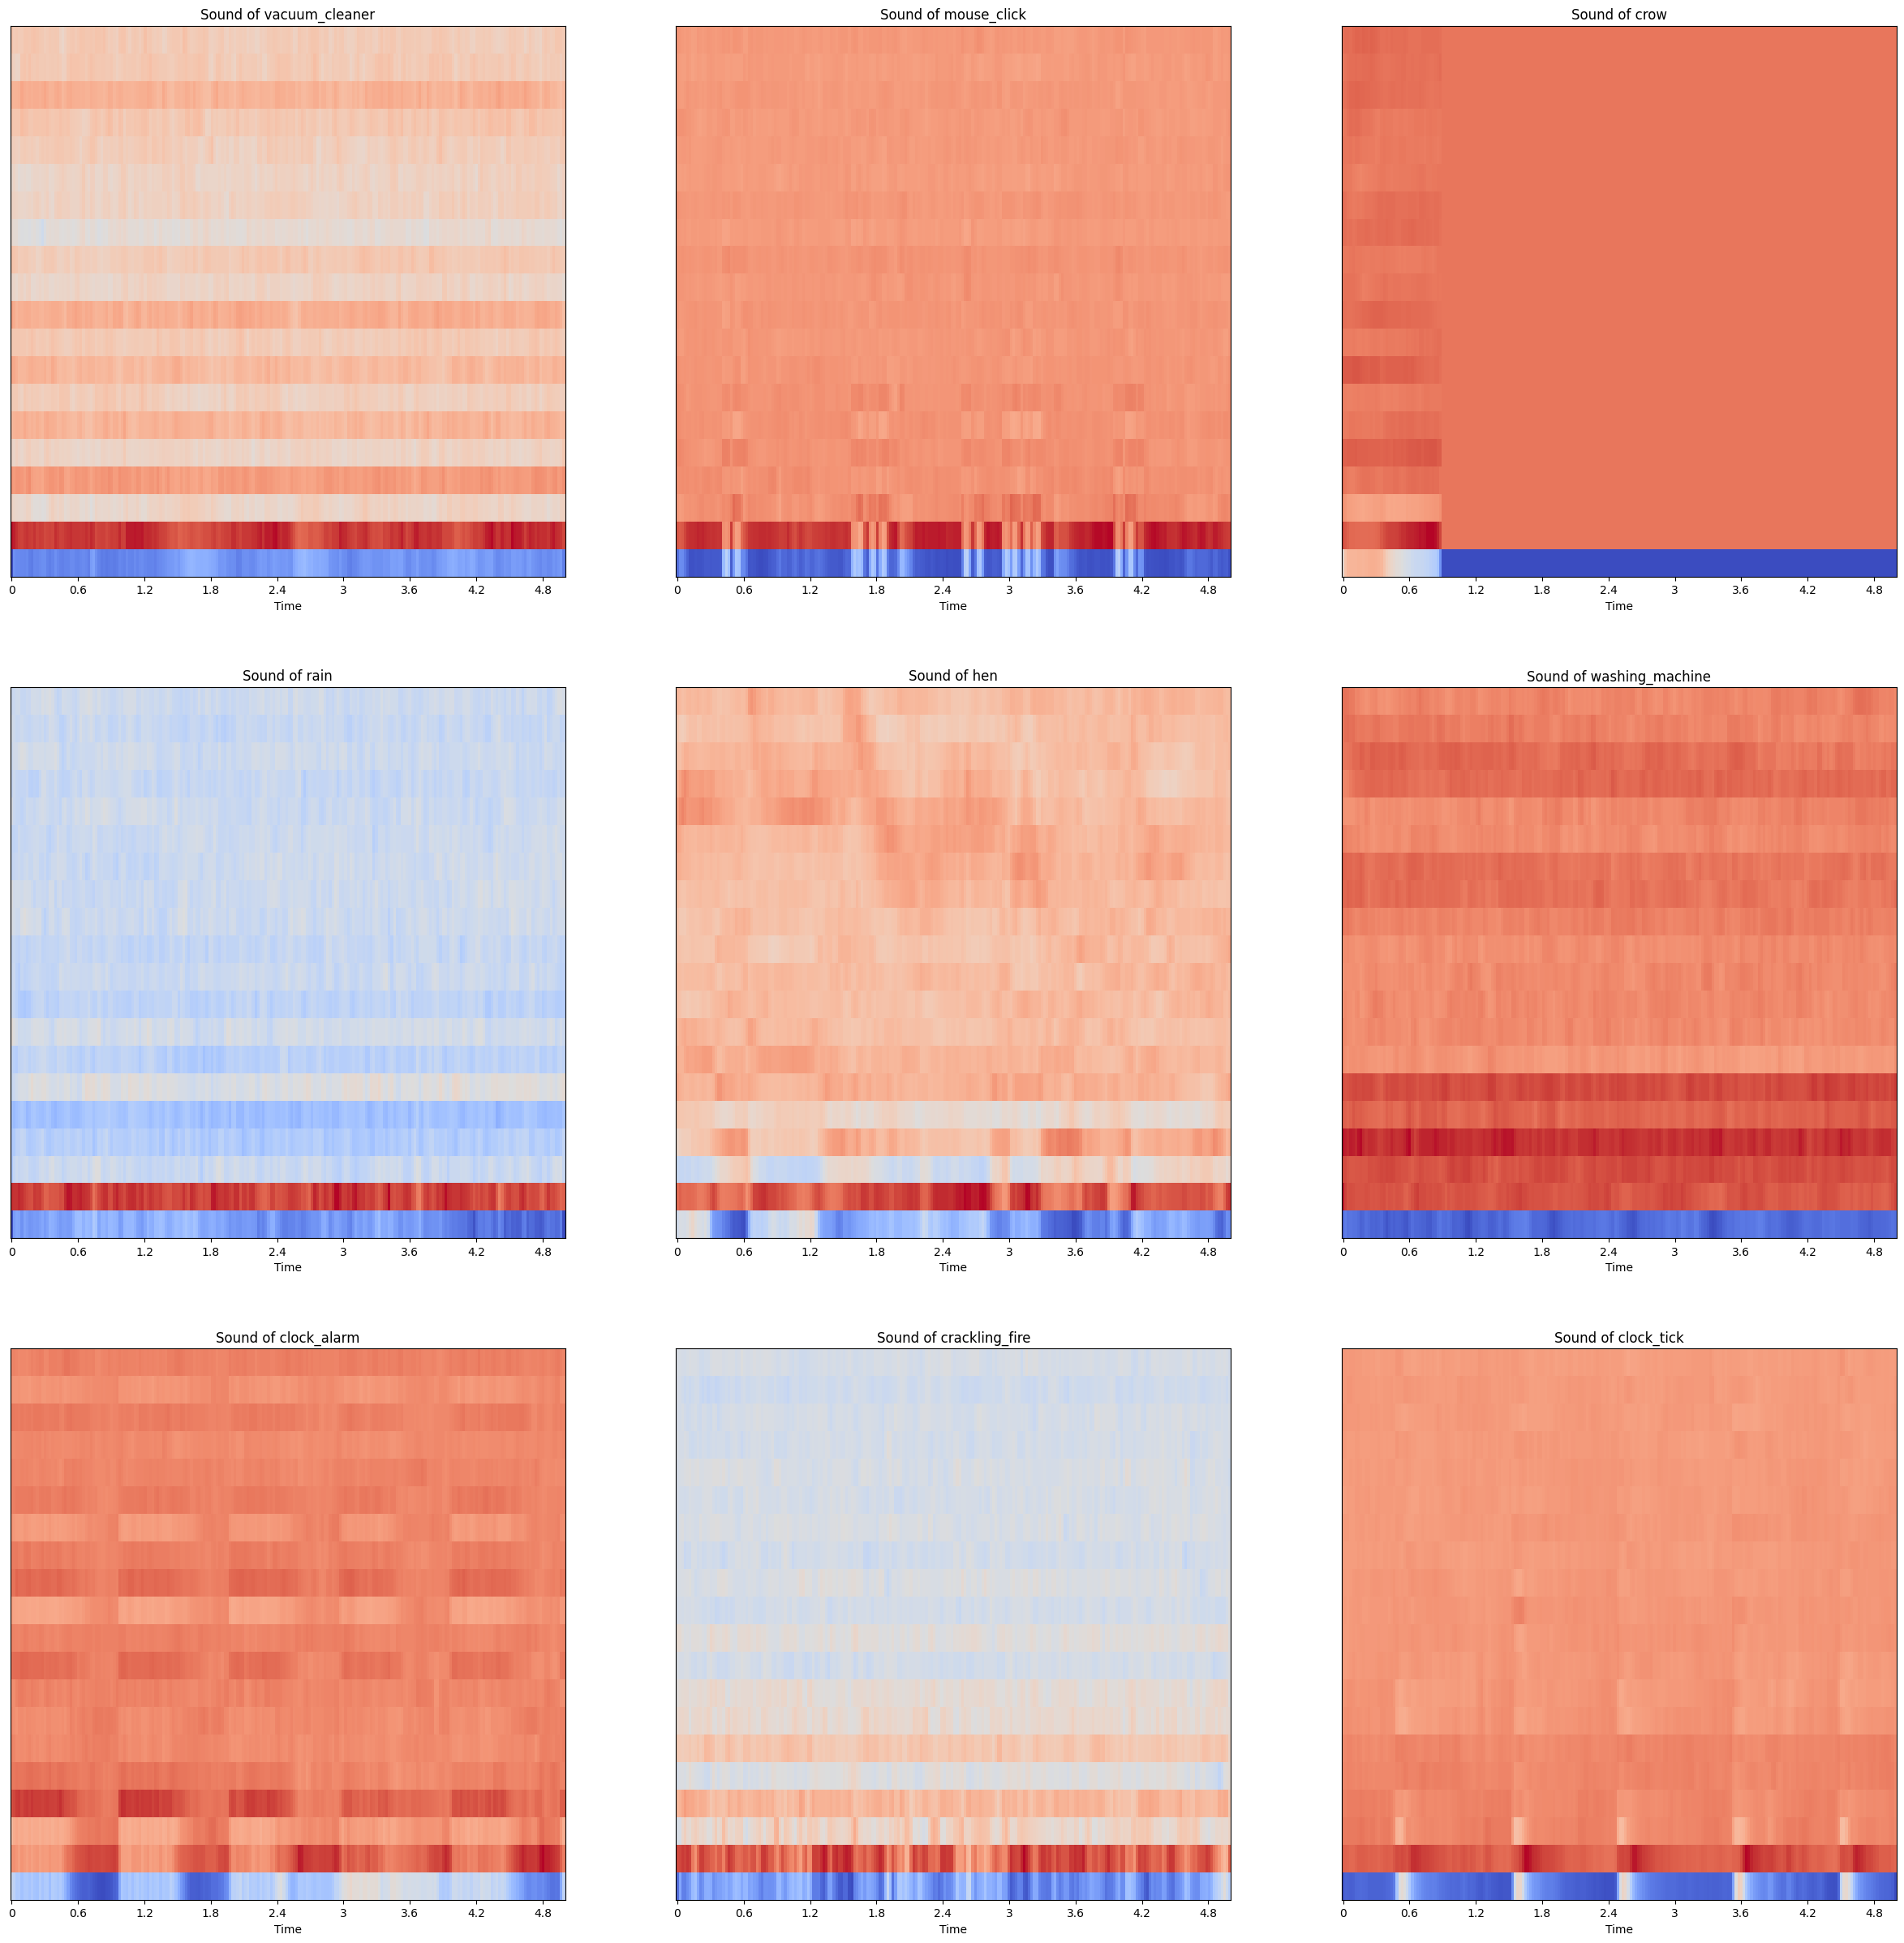

In [21]:
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    mfccs = librosa.feature.mfcc(y=plot_audios[i][0], sr=plot_audios[i][1])
    librosa.display.specshow(mfccs, sr=plot_audios[i][1], x_axis='time')
    try:
        plt.title("Sound of " + decoder[int(plot_files[i][-6:-4])] )
    except:
        plt.title("Sound of " + decoder[int(plot_files[i][-5:-4])] )

## **Data Augmention**

In [72]:
# create augmented folder 
os.makedirs(AUGMENTED_PATH, exist_ok=True)

In [73]:
# save augmented data 
def save_augmented_audio(filename, data, sr=16000):
   sf.write(filename, data, sr)

def add_noise(data):
    noise = np.random.normal(0, 0.02, len(data))
    return data + noise

def pitch_shifting(data, sr=16000):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform())
    return librosa.effects.pitch_shift(data.astype(np.float32), sr=sr, n_steps=pitch_change, bins_per_octave=bins_per_octave)

def random_shift(data):
    shift = int(np.random.uniform(-0.2, 0.2) * len(data))
    return np.roll(data, shift)

def volume_scaling(data):
    return data * np.random.uniform(0.7, 1.3)

def time_stretching(data, rate=1.5):
    return librosa.effects.time_stretch(data.astype(np.float32), rate=rate)

def volume_change(data, gain=3):
   return data * (10**(gain / 20))

def add_time_delay(data, delay_samples=1000):
    """
    Adds a time delay to an audio signal.

    :param data: The original audio signal.
    :param delay_samples: The number of samples to delay the signal by.
    :return: The audio signal with the applied delay effect.
    """
    delayed_signal = np.zeros_like(data)
    delayed_signal[delay_samples:] = data[:-delay_samples]
    return data + 0.5 * delayed_signal  

In [74]:
print("\n🟢 Starting Data Augmentation...")  # Notify the start of data augmentation

augmented_files = []  # List to store paths of augmented audio files
augmented_targets = []  # List to store corresponding labels

# Iterate through each row in the dataset
for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
    file_path = row["files_path"]  # Get the file path of the audio
    label = row["target"]  # Get the corresponding target label

    try:
        # Load the audio file with a sample rate of 16,000 Hz
        data, sr = librosa.load(file_path, sr=16000)

        # Apply various data augmentation techniques
        augmentations = [
            add_noise(data),  # Add Gaussian noise
            pitch_shifting(data, sr=sr),  # Apply pitch shifting
            random_shift(data),  # Apply random time shifting
            volume_scaling(data),  # Apply volume scaling
            time_stretching(data, rate=1.5),  # Apply time stretching
            volume_change(data, gain=3),  # Change volume by a gain of 3dB
            add_time_delay(data, delay_samples=1000)  # Add a time delay effect
        ]

        # Save the augmented audio files
        for idx, aug_data in enumerate(augmentations):
            aug_filename = f"{row['filename'][:-4]}.wav"  # Generate new filename
            aug_filepath = os.path.join(AUGMENTED_PATH, aug_filename)  # Define the save path
            save_augmented_audio(aug_filepath, aug_data, sr)  # Save the augmented audio

            # Store the augmented file path and its corresponding label
            augmented_files.append(aug_filepath)
            augmented_targets.append(label)

    except Exception as e:
        # Handle exceptions and print an error message
        print(f"⚠️ Error during data augmentation for file {file_path}: {e}")


🟢 Starting Data Augmentation...


100%|██████████| 2000/2000 [01:59<00:00, 16.78it/s]


In [76]:
dataset_aug = pd.DataFrame({"files_path": augmented_files, "target": augmented_targets})
dataset = pd.concat([dataset, dataset_aug], ignore_index=True)
print(f"\n🟢 Total number of samples after augmentation: {len(dataset)}")  


🟢 Total number of samples after augmentation: 16000


In [77]:
dataset.shape

(16000, 8)

## **Pre-Processing Data**

In [79]:
# ✅ extract sound feature
features = ['zero_crossing_rate', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
            'beat_per_minute', 'rolloff'] + [f'mfcc_{i}' for i in range(20)]

for feature in features:
    dataset[feature] = np.zeros(len(dataset))

for i in tqdm(range(len(dataset))):
    file_path = dataset['files_path'][i]
    if os.path.exists(file_path):
        y, sr = librosa.load(file_path, mono=True)
        dataset.at[i, 'rmse'] = np.mean(librosa.feature.rms(y=y))
        dataset.at[i, 'chroma_stft'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
        dataset.at[i, 'spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        dataset.at[i, 'spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
        dataset.at[i, 'rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
        dataset.at[i, 'zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        dataset.at[i, 'beat_per_minute'] = tempo
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        for e in range(20):
            dataset.at[i, f'mfcc_{e}'] = np.mean(mfcc[e])

  1%|          | 109/16000 [00:05<13:15, 19.99it/s]c:\Users\fury14\miniconda3\envs\audio\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 16000/16000 [14:10<00:00, 18.81it/s]


In [81]:
dataset.shape

(16000, 35)